Groundwater | Case Study

# Topic 4b : From Concept to Code: Adding Transport Processes to a Groundwater Flow Model

Dr. Xiang-Zhao Kong & Dr. Beatrice Marti & Louise Noël du Payrat

---

## 1. Overview: Learning Path for Contaminant Transport Modeling

This notebook demonstrates how to add contaminant transport processes to an existing groundwater flow model. We follow a systematic approach that builds confidence through verification before tackling complex problems.

### 1.1 The Problem: Contaminant Plume Migration

**Scenario:** A point source releases contaminants into the Limmat Valley aquifer. We need to predict:
- How far will the plume migrate?
- What concentrations will reach downstream locations?
- Can we trust our numerical model predictions?

### 1.2 The Approach: Simple to Complex

Rather than immediately jumping to a complex 2.5D Limmat Valley model, we follow professional best practice:

**Step 1: Learn the Theory (Section 2)**
- Understand transport processes (advection, dispersion, reactions)
- Learn the governing equations with forcing terms
- Understand how MT3D-USGS couples with MODFLOW

**Step 2: Verify with Analytical Solution (Section 3)**
- Implement the analytical solution for 1D pulse source transport problem
- Understand what the "correct" answer should look like
- Test the analytical solution with different parameters

**Step 3: Verify MT3D with 1D Test (Section 4)**
- Create idealized 1D uniform flow case with MODFLOW
- Run MT3D-USGS with proper grid resolution (Pe = 0.5)
- Compare MT3D results to pulse source analytical solution
- **Result:** Builds confidence that MT3D works correctly

**Step 4: Load Real Flow Model (Section 5)**
- Load existing Limmat Valley MODFLOW model
- Verify steady-state flow field
- Prepare for transport coupling

**Step 5: Apply to 2.5D Limmat Valley (Section 6)**
- Define point source location in real aquifer
- Run MT3D on existing 50m grid (Pe = 5)
- Observe numerical artifacts from coarse grid
- **Result:** Understand limitations and when to refine

**Step 6: Diagnose and Fix (Section 6.10 + Section 7)**
- Diagnose why Pe = 5 causes problems
- Introduce telescope approach for grid refinement
- Achieve reliable results like Section 4

### 1.3 Why This Structure?

**Analytical First:** Section 3 shows the "correct" answer from theory. Section 4 proves MT3D can reproduce it when properly configured. Without these baselines, we wouldn't know if Section 6 problems are bugs or numerical artifacts.

**Controlled Comparison:** By keeping everything identical except grid resolution:
- Section 4: Pe = 0.5 → excellent results ✓
- Section 6: Pe = 5.0 → numerical issues ❌

This teaches the critical lesson: **numerical modeling is more about proper setup than fancy software**.

**Pedagogical Value:**
- Students see analytical solution first (understand the physics)
- Then verify MT3D can reproduce it (build confidence in tool)
- Experience both success (Section 4) and failure (Section 6)
- Learn to diagnose problems (Peclet number check)
- Practice professional workflow: theory → analytical → verify → apply → diagnose → refine

### 1.4 Learning Outcomes

By the end of this notebook, you will:
1. ✓ Understand analytical solutions for transport (pulse source)
2. ✓ Implement and test analytical solutions in Python
3. ✓ Set up complete MT3D models (all packages: BTN, ADV, DSP, SSM, GCG)
4. ✓ Verify numerical solutions against analytical benchmarks
5. ✓ Diagnose grid resolution problems using Peclet and Courant numbers
6. ✓ Recognize when numerical results are trustworthy vs when they're artifacts
7. ✓ Apply professional best practices: understand theory before coding

### 1.5 Notebook Structure

```
Section 2: Transport Theory
  ├─ Fundamental processes
  ├─ Governing equations with forcing terms
  └─ MT3D-USGS packages

Section 3: Analytical Solution (Pulse Source)
  ├─ Implement analytical function
  ├─ Test with different parameters
  └─ Visualize analytical solution

Section 4: 1D MT3D Verification (Pe = 0.5)
  ├─ Build simple 1D MODFLOW model
  ├─ Set up MT3D with fine grid
  ├─ Compare to analytical solution
  └─ Result: <10% error → MT3D works! ✓

Section 5: Load Limmat Valley Flow Model
  ├─ Load MODFLOW model
  ├─ Run steady-state flow
  └─ Prepare for transport coupling

Section 6: 2.5D Limmat Valley (Pe = 5.0)
  ├─ Define point source
  ├─ MT3D on 50m grid
  ├─ Observe numerical artifacts
  └─ Diagnose: Grid too coarse! ❌

Section 7+: Solutions
  └─ Telescope approach for refinement
```

### 1.6 The Key Insight

**Analytical → Numerical verification → Real application**

This workflow ensures you:
- Understand the physics (analytical)
- Trust your tools (verification)
- Know when results are reliable (diagnostics)

Grid resolution (measured by Peclet number) determines whether results are trustworthy.

**Ready?** Let's start with transport theory fundamentals in Section 2.

---
## 2. Introduction to Contaminant Transport Modeling

Contaminant transport in groundwater is governed by physical, chemical, and biological processes. Understanding these processes is essential for predicting plume migration, assessing risks, and designing remediation strategies.

### 2.1 Fundamental Transport Processes

**Advection** is the movement of dissolved contaminants with flowing groundwater:

$$u = \frac{K \cdot i}{\phi_e}$$

where $u$ is pore water velocity (m/day), $K$ is hydraulic conductivity (m/day), $i$ is hydraulic gradient (m/m), and $\phi_e$ is effective porosity (dimensionless).

**Dispersion** causes spreading of the contaminant plume beyond what advection alone would predict. It results from:
- **Mechanical dispersion**: Variations in velocity at pore scale and between flow paths
- **Molecular diffusion**: Random motion of molecules (typically negligible compared to mechanical dispersion)

**Sorption** is the attachment of contaminants to aquifer solids, causing **retardation**:

$$R = 1 + \frac{(1-\phi_e) \cdot \rho_s \cdot K_s}{\phi_e}$$

where $R$ is the retardation factor (dimensionless), $\rho_s$ is solid density (kg/m³), and $K_s$ is the distribution coefficient (mL/g).

**Decay** represents biodegradation or chemical transformation:

$$c(t) = c_0 \cdot e^{-\lambda t}$$

where $\lambda$ is the first-order decay constant (1/day), related to half-life by $t_{1/2} = \ln(2)/\lambda$.

### 2.2 Governing Equation

The 3D advection-dispersion-reaction equation describes contaminant transport:

$$
R \frac{\partial c}{\partial t} = \nabla \cdot (D \nabla c) - \mathbf{u} \cdot \nabla c - \lambda R c
$$

where:
- $c$ = concentration (mg/L or kg/m³)
- $t$ = time (days)
- $D$ = dispersion tensor (m²/day)
- $\mathbf{u}$ = velocity vector (m/day)
- $\lambda$ = decay constant (1/day)

### 2.3 Formulation of the Transport Problem with Forcing Terms

#### Complete Transport Equation with Sources/Sinks

The **full form** of the transport equation includes **forcing terms** (sources and sinks):

$$
R \frac{\partial c}{\partial t} = \nabla \cdot (D \nabla c) - \nabla \cdot (\mathbf{u} c) - \lambda R c + \frac{q_s c_s}{\phi_e}
$$

where the **forcing term** $\frac{q_s c_s}{\phi_e}$ represents:
- $q_s$ = volumetric flow rate per unit volume of aquifer (1/day) - positive for injection, negative for extraction
- $c_s$ = concentration in the source/sink water (kg/m³)
- $\phi_e$ = effective porosity (dimensionless)

#### Physical Interpretation of Forcing Terms

**1. Point Sources (Constant Concentration)**
- Continuous spill or leak
- Implemented as: **Dirichlet boundary condition** $c(x_s, y_s, z_s, t) = c_0$
- MT3D implementation: `icbund = -1`, `sconc = c_0`

**2. Mass Loading Sources**
- Direct injection of mass into aquifer
- Rate: $\dot{M} = q_s \cdot c_s$ (kg/day)
- MT3D implementation: SSM package with `itype = 15`

**3. Well Sources/Sinks**
- **Injection well**: $q_s > 0$, introduces contaminant at concentration $c_s$
- **Pumping well**: $q_s < 0$, removes water at ambient concentration $c$
- MT3D implementation: SSM package with `itype = 2` (coupled to MODFLOW WEL package)

**4. Boundary Sources**
- Rivers: SSM with `itype = 4` (RIV package)
- Drains: SSM with `itype = 3` (DRN package)  
- General head boundaries: SSM with `itype = 5` (GHB package)

#### Mathematical Form for Different Source Types

**Constant concentration source (Dirichlet BC):**
$$c(\mathbf{x}_s, t) = c_0 \quad \text{for} \quad \mathbf{x} \in \Omega_s$$

**Mass injection source:**
$$\frac{\partial c}{\partial t} = \ldots + \frac{\dot{M}(t)}{\phi_e \cdot V_{cell}}$$

where $\dot{M}(t)$ is the mass injection rate (kg/day) and $V_{cell}$ is the cell volume (m³).

**Well extraction (sink):**
$$\frac{\partial c}{\partial t} = \ldots - \frac{Q_{well} \cdot c}{\phi_e \cdot V_{cell}}$$

where $Q_{well}$ is the pumping rate (m³/day), removing water at the local concentration $c$.

#### Units and Consistency

**CRITICAL:** MT3D-USGS requires consistent units with MODFLOW:

| Quantity | MODFLOW Unit | MT3D Unit | Conversion |
|----------|--------------|-----------|------------|
| Length | m | m | - |
| Time | days | days | - |
| Mass | - | kg | - |
| Concentration | - | kg/m³ | mg/L × 0.001 |
| Velocity | m/day | m/day | - |
| Dispersion coeff | m²/day | m²/day | - |
| Well flow | m³/day | m³/day | - |
| Mass rate | - | kg/day | - |

**Example conversions:**
- 100 mg/L = 0.1 kg/m³
- 1 g/L = 1 kg/m³
- Well at 1000 m³/day with 50 mg/L → injects 0.05 kg/day of mass

#### Boundary and Initial Conditions

**Initial condition (t = 0):**
$$c(\mathbf{x}, 0) = c_0(\mathbf{x})$$

Typically $c_0 = 0$ everywhere except at sources.

**Boundary conditions:**

1. **Dirichlet (specified concentration):**
   $$c = c_b \quad \text{on} \quad \Gamma_D$$
   
2. **Neumann (specified flux):**
   $$-D \nabla c \cdot \mathbf{n} = F_b \quad \text{on} \quad \Gamma_N$$

3. **Cauchy (flux proportional to concentration):**
   $$-D \nabla c \cdot \mathbf{n} + \mathbf{u} \cdot \mathbf{n} \, c = 0 \quad \text{on} \quad \Gamma_C$$

4. **No-flow boundary:**
   $$\nabla c \cdot \mathbf{n} = 0 \quad \text{on} \quad \Gamma_{NF}$$

where $\mathbf{n}$ is the outward normal vector on the boundary.

#### Solution Strategy in MT3D-USGS

MT3D solves the transport equation using:

1. **Operator splitting**:
   - Step 1: Advection (MOC, HMOC, MMOC, or TVD scheme)
   - Step 2: Dispersion/diffusion (implicit finite difference)
   - Step 3: Reactions (analytical or implicit)
   - Step 4: Sources/sinks (SSM package)

2. **Coupling with MODFLOW**:
   - Read velocity field from `.cbc` (cell-by-cell) file
   - Read well/boundary fluxes from MODFLOW output
   - Apply source concentrations via SSM package

3. **Mass balance**:
   MT3D tracks mass entering/leaving via:
   - Constant concentration boundaries
   - Wells (injection/extraction)
   - Boundaries (rivers, drains, GHB)
   - Decay/reactions

#### Key Takeaways for Modeling

✓ **Sources must be properly configured** - Wrong unit conversions → wrong results  
✓ **Well injection ≠ constant concentration** - Different mathematical formulations  
✓ **Mass balance is essential** - Always check mass conservation in `.mas` file  
✓ **Boundary conditions matter** - Plumes must stay within domain or have proper BCs  
✓ **Forcing terms are additive** - Multiple sources sum together in the equation

**Next section** covers analytical vs. numerical solutions, where we'll see how forcing terms appear in analytical solutions (e.g., the pulse solution uses an instantaneous point mass source at x=0).

### 2.4 Analytical vs. Numerical Solutions

**Analytical solutions** exist for simplified conditions (1D, uniform flow, simple boundaries). **Example**: solution for 1D pulse source:

$$c(x,t) = \frac{M/(\phi_e \cdot A)}{\sqrt{4 \pi D_L t}} \exp\left(-\frac{(x - ut)^2}{4 D_L t}\right) \exp(-\lambda t)$$

where:
- $M$ = mass released (kg)
- $\phi_e$ = effective porosity (dimensionless)
- $A$ = cross-sectional area (m²)
- $D_L$ = longitudinal dispersion coefficient (m²/day)
- $u$ = average linear velocity (m/day)   
- $ \lambda $ = decay constant (1/day)
- $x$ = distance from source (m)
- $t$ = time (days)
- $c(x,t)$ = concentration at location $x$ and time $t$ (kg/m³)

**Numerical solutions** (MT3D-USGS, MODFLOW 6 GWT) handle complex 2D/3D geometries, heterogeneity, wells, and boundaries.

### 2.5 MT3D-USGS: Modular Transport Simulator

MT3D-USGS (Bedekar et al., 2016) is the USGS version of MT3DMS, coupled with MODFLOW. It uses a **modular package structure**:

| Package | Purpose | Key Parameters |
|---------|---------|----------------|
| **BTN** | Basic Transport | Porosity, initial concentration, time steps |
| **ADV** | Advection | Numerical scheme (MOC, TVD, etc.) |
| **DSP** | Dispersion | Dispersivity ($\alpha_L$, $\alpha_T$, $\alpha_V$) |
| **SSM** | Source-Sink Mixing | Source locations and concentrations |
| **RCT** | Reactions | Sorption ($K_d$), decay ($\lambda$) |
| **GCG** | Solver | Convergence criteria |

MT3D reads flow velocities from MODFLOW output and solves transport on the same (or refined) grid.

### 2.6 When to Use Which Method?

```
Simple problem? → Try analytical first
├─ Uniform flow, 1D, no wells → Ogata-Banks
├─ Conservative tracer only → Particle tracking (MODPATH)
└─ Need verification → Always compare numerical to analytical

Complex problem? → Use numerical model
├─ Wells, boundaries, heterogeneity → MT3D-USGS
├─ Multiple contaminants → MT3D-USGS (multi-species)
└─ Regulatory/design decisions → MT3D-USGS (defensible)
```

**Professional practice**: Start simple, add complexity only when justified. Always verify numerical models against analytical solutions.

### 2.7 References

- Sale, T., & Scalia, J. (2025). Modern Subsurface Contaminant Hydrology, first edition. The Groundwater Project. [https://doi.org/10.62592/IQDO4854](https://doi.org/10.62592/IQDO4854).
- Bedekar, Vivek, Morway, E.D., Langevin, C.D., and Tonkin, Matt, 2016, MT3D-USGS version 1: A U.S. Geological Survey release of MT3DMS updated with new and expanded transport capabilities for use with MODFLOW: U.S. Geological Survey Techniques and Methods 6-A53, 69 p., [https://dx.doi.org/10.3133/tm6A53](https://dx.doi.org/10.3133/tm6A53).
- Ogata, A., & Banks, R.B. (1961). *Longitudinal Dispersion in Porous Media*. USGS Professional Paper 411-A. [https://pubs.usgs.gov/pp/0411a/report.pdf](https://pubs.usgs.gov/pp/0411a/report.pdf).
- Gelhar, L.W., et al. (1992). Field-scale dispersion in aquifers. *Water Resources Research*, 28(7), 1955-1974. [https://doi.org/10.1029/92WR00607](https://doi.org/10.1029/92WR00607).

---

Let's now see these concepts in practice with code examples in Section 3.

---
## 3. Analytical Solution: Pulse Source for 1D Transport

Before building any numerical models, let's first understand the analytical solution. Though you have covered other solutions in class, we will focus on the pulse source solution here for simplicity reasons. The pulse source solution provides the "correct" answer for 1D transport with uniform flow and an instantaneous concentration source.

You can choose to use other solutions, already implemented for example in the adepy package, for your case study projects. 

### 3.1 The Pulse Source Solution

For 1D transport along a semi-infinite domain with:
- Uniform groundwater velocity $u$ (m/day)
- Longitudinal dispersion coefficient $D_L = \alpha_L \cdot u$ (m²/day)
- Instantaneous source release of Mass $M$ at $x = 0$
- Initially clean aquifer ($C = 0$ at $t = 0$)

The concentration at distance $x$ and time $t$ is:

$$c(x,t) = \frac{M/(\phi_e \cdot A)}{\sqrt{4 \cdot \pi \cdot D_L \cdot t}} \cdot \exp{\left[\frac{-(x - u \cdot t)^2}{4 \cdot D_L \cdot t}\right]}$$

assuming that the mass M is released instantaneously at t=0 at location x=0.

**Physical interpretation:**
- Advective-dispersive front moving at velocity $u$
- **At source ($x=0$)**: $C(0,t) = C_0$ (matches boundary condition)

### 3.2 Implement Pulse Source Function

Let's look at the analytical solution as implemented in the adepy package and compare the function to the analytical expression above.

In [1]:
from scipy.special import erfc
import numpy as np
import matplotlib.pyplot as plt
! pip install adepy
import adepy
from adepy.uniform.oneD import pulse1

# Implementation of the analytical solution to 1D transport from an instantaneous 
# pulse source as implemented in adepy. In order not to overwrite the adepy function,
# we name this function pulse1_demo. We import the original adepy function 
# in the line above.
def pulse1_demo(m0, x, t, v, n, al, xc=0.0, Dm=0.0, lamb=0.0, R=1.0):
    """Compute the 1D concentration field of a dissolved solute from an instantaneous pulse point source in an infinite aquifer
    with uniform background flow.

    Source: [bear_1979]

    The one-dimensional advection-dispersion equation is solved for concentration at specified `x` location(s) and
    output time(s) `t`. An infinite system with uniform background flow in the x-direction is subjected to a pulse source
    with mass `m0` at `xc` at time `t=0`.
    The solute can be subjected to 1st-order decay. Since the equation is linear, multiple sources can be superimposed
    in time and space.
    Note that the equation has the same shape as the probability density function of a Gaussian distribution.

    The mass center of the plume at a given time `t` can be found at `x=xc + v*t/R`.

    Parameters
    ----------
    m0 : float
        Source mass [M].
    x : float or 1D of floats
        x-location(s) to compute output at [L].
    t : float or 1D of floats
        Time(s) to compute output at [T].
    v : float
        Average linear groundwater flow velocity of the uniform background flow in the x-direction [L/T].
    n : float
        Aquifer porosity. Should be between 0 and 1 [-].
    al : float
        Longitudinal dispersivity [L].
    xc : float
        x-coordinate of the point source [L], defaults to 0.0.
    Dm : float, optional
        Effective molecular diffusion coefficient [L**2/T]; defaults to 0 (no molecular diffusion).
    lamb : float, optional
        First-order decay rate [1/T], defaults to 0 (no decay).
    R : float, optional
        Retardation coefficient [-]; defaults to 1 (no retardation).

    Returns
    -------
    ndarray
        Numpy array with computed concentrations [M/L**3] at location(s) `x` and time(s) `t`.

    References
    ----------
    .. [bear_1979] Bear, J., 1979. Hydraulics of Groundwater. New York, McGraw Hill, 596 p.

    """
    x = np.atleast_1d(x)
    t = np.atleast_1d(t)

    D = al * v + Dm

    # apply retardation coefficient to right-hand side
    v = v / R
    D = D / R

    term0 = (
        1
        / (n * np.sqrt(4 * np.pi * D * t))
        * np.exp(-((x - xc - v * t) ** 2) / (4 * D * t) - lamb * t)
    )

    return m0 * term0

# Test the function with example parameters
x_test = np.array([0, 50, 100, 150, 200, 250, 300])  # m
t_test = 365  # 1 year
M_test = 10  # kg
u_test = 0.4  # m/day
alpha_L_test = 10.0  # m
D_test = alpha_L_test * u_test  # 4.0 m²/day
phi_e_test = 0.2  # effective porosity

C_test = pulse1(
    m0=M_test, 
    x=x_test,
    t=t_test,
    v=u_test,
    n=phi_e_test, 
    al=alpha_L_test)

print("Pulse source function test:")
print(f"Parameters:")
print(f"  Source mass: {M_test} kg ")
print(f"  Velocity: {u_test} m/day")
print(f"  Dispersivity: {alpha_L_test} m")
print(f"  Dispersion coefficient: {D_test} m²/day")
print(f"  Time: {t_test} days ({t_test/365:.1f} years)")
print(f"\nConcentrations at different distances:")
for i, x_val in enumerate(x_test):
    print(f"  x = {x_val:3.0f} m: C = {C_test[i]:.6f} kg/m³ ({C_test[i]*1e3:.1f} mg/L)")


Pulse source function test:
Parameters:
  Source mass: 10 kg 
  Velocity: 0.4 m/day
  Dispersivity: 10.0 m
  Dispersion coefficient: 4.0 m²/day
  Time: 365 days (1.0 years)

Concentrations at different distances:
  x =   0 m: C = 0.009594 kg/m³ (9.6 mg/L)
  x =  50 m: C = 0.076179 kg/m³ (76.2 mg/L)
  x = 100 m: C = 0.256940 kg/m³ (256.9 mg/L)
  x = 150 m: C = 0.368128 kg/m³ (368.1 mg/L)
  x = 200 m: C = 0.224047 kg/m³ (224.0 mg/L)
  x = 250 m: C = 0.057923 kg/m³ (57.9 mg/L)
  x = 300 m: C = 0.006361 kg/m³ (6.4 mg/L)


The output concentrations at different distances after 1 year of transport from an instantaneous pulse source find a maximum around the distance of 150 m.  

> **At which distance is the peak concentration located after 1 year?**
<details>
<summary>Solution</summary>
You can calculate the distance of peak = velocity * time: 0.4 m/day * 365 days = 146 m
</details>

### 3.3 Visualize Analytical Solution
Let's visualize the analytical solution of the 1D instantaneous pulse source problem for different times and distances.

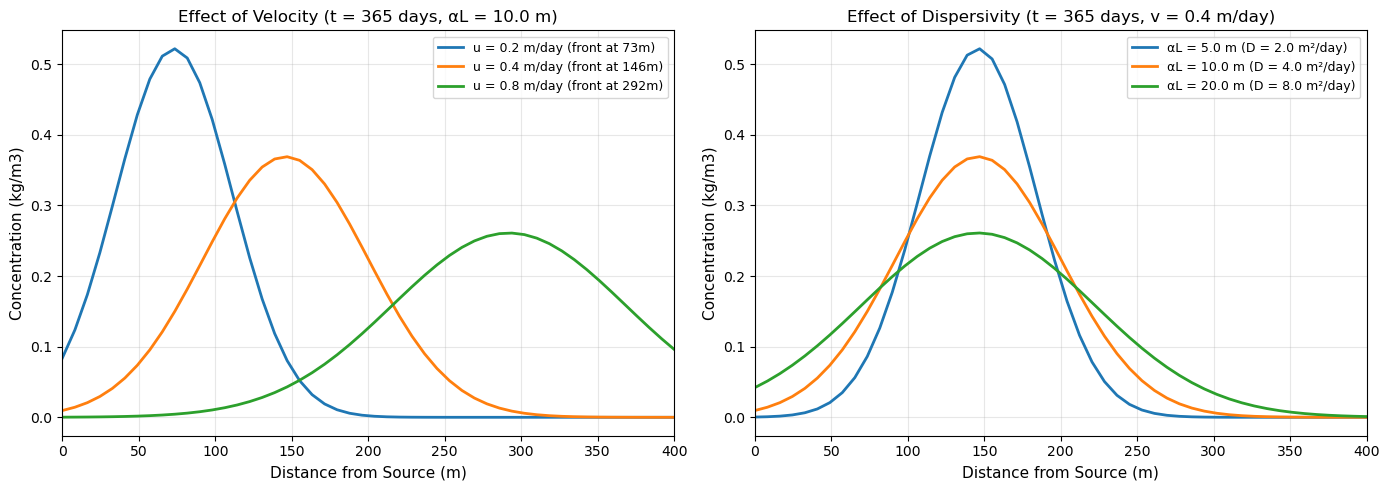


Parameter sensitivity insights:
  • Velocity controls front position (higher v → faster migration)
  • Dispersivity controls spreading (higher αL → more dispersion)
  • Both affect plume shape and maximum concentration


In [2]:
# Parameter sensitivity analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

t_sensitivity = 365  # Fixed time (1 year)
x_sens = np.linspace(0, 400)

# Left plot: Effect of velocity
ax1 = axes[0]
velocities = [0.2, 0.4, 0.8]  # m/day
alpha_L_fixed = 10.0  # m

for u_sens in velocities:
    D_sens = alpha_L_fixed * u_sens
    C_sens = pulse1(m0=M_test, x=x_sens, t=t_sensitivity, v=u_sens, n=phi_e_test, al=alpha_L_fixed)
    ax1.plot(x_sens, C_sens, linewidth=2, 
             label=f'u = {u_sens} m/day (front at {u_sens*t_sensitivity:.0f}m)')

ax1.set_xlabel('Distance from Source (m)', fontsize=11)
ax1.set_ylabel('Concentration (kg/m3)', fontsize=11)
ax1.set_title(f'Effect of Velocity (t = {t_sensitivity} days, αL = {alpha_L_fixed} m)', fontsize=12)
ax1.grid(alpha=0.3)
ax1.legend(fontsize=9)
ax1.set_xlim(0, 400)

# Right plot: Effect of dispersivity
ax2 = axes[1]
u_fixed = 0.4  # m/day
dispersivities = [5.0, 10.0, 20.0]  # m

for alpha_L_sens in dispersivities:
    D_sens = alpha_L_sens * u_fixed
    C_sens = pulse1(m0=M_test, x=x_sens, t=t_sensitivity, v=u_fixed, n=phi_e_test, al=alpha_L_sens)
    ax2.plot(x_sens, C_sens, linewidth=2, 
             label=f'αL = {alpha_L_sens} m (D = {D_sens:.1f} m²/day)')

ax2.set_xlabel('Distance from Source (m)', fontsize=11)
ax2.set_ylabel('Concentration (kg/m3)', fontsize=11)
ax2.set_title(f'Effect of Dispersivity (t = {t_sensitivity} days, v = {u_fixed} m/day)', fontsize=12)
ax2.grid(alpha=0.3)
ax2.legend(fontsize=9)
ax2.set_xlim(0, 400)

plt.tight_layout()
plt.show()

print("\nParameter sensitivity insights:")
print("  • Velocity controls front position (higher v → faster migration)")
print("  • Dispersivity controls spreading (higher αL → more dispersion)")
print("  • Both affect plume shape and maximum concentration")

### 3.4 Summary: Analytical Solution Established

**What we accomplished in Section 3:**

✅ **Implemented 1D instantaneous pulse solution** in Python  
✅ **Visualized plume evolution** over time  
✅ **Explored parameter sensitivity** (velocity and dispersivity)

**Key learning outcomes:**

1. **Understand the physics** - Analytical solution shows pure advection-dispersion
2. **Know the "correct" answer** - This is our benchmark for verification
3. **Parameter intuition** - Velocity moves plume, dispersivity spreads it
4. **Baseline established** - Now we can test if MT3D reproduces this

**Next:** Section 4 will implement a 1D numerical model with MT3D-USGS and compare results to this analytical solution. We expect excellent agreement (< 10% error) when grid resolution is adequate (Pe ≤ 2).

---
## 4. Numerical Verification: 1D MT3D-USGS Model

Now that we've established the analytical solution in Section 3, let's verify that MT3D-USGS can reproduce it. This builds confidence that the numerical code works correctly before applying it to complex problems.

### 4.1 Why Verify Against Analytical Solution?

**Professional practice:** Always test numerical models on simple cases with known solutions before tackling complex problems.

**Benefits:**
1. **Build confidence** - Verify MT3D physics are correct
2. **Understand parameters** - Learn how grid resolution affects results
3. **Test workflow** - Debug setup issues in simple context
4. **Establish baseline** - Know what "good agreement" looks like
5. **Learn resolution requirements** - See effect of grid size and time step

**The plan:**
- Set up simple 1D column with uniform flow
- Use **fine grid** (Δx = 5m) → Pe = 5/10 = **0.5** ✓
- Use small time steps (Δt = 2.5 days) → Cr = **0.8** ✓
- Compare MT3D results to the 1D analytical solution from Section 3
- Expect excellent agreement (within 5-10%)

### 4.2 Model Design for Verification

**Key parameters matching Section 3 analytical solution:**
- Domain: 500m long, 50m wide, 10m thick (1 layer)
- Grid: Δx = 5m (100 cells) → **Pe = 5/10 = 0.5** ✓
- Hydraulic gradient: i = 0.002 (uniform)
- Hydraulic conductivity: K = 50 m/day
- Porosity: n = 0.25
- Seepage velocity: v = K·i/n = 50 × 0.002 / 0.25 = **0.4 m/day**
- Dispersivity: αL = 10 m
- Dispersion coefficient: D = 10 × 0.4 = **4 m²/day**
- Time step: Δt = 2.5 days → **Cr = 0.4·2.5/(0.25·5) = 0.8** ✓
- Simulation: 1000 days

**Note:** These match the parameters we used in Section 3.2 for testing the analytical solution!

### 4.3 Set Up 1D MODFLOW Model

First, we need to create a MODFLOW model that produces uniform flow.

In [3]:
# Import additional libraries for 1D verification model
import flopy

# Define workspace
import pathlib
from pathlib import Path

transport_ws = Path.home() / "applied_groundwater_modelling_data" / "limmat" / "transport"
transport_ws.mkdir(exist_ok=True)

# Create workspace for 1D model
model_1d_ws = transport_ws / "test_1d"
model_1d_ws.mkdir(exist_ok=True)

# Model parameters for 1D uniform flow
Lx = 500.0   # Length (m)
Ly = 1.0    # Width (m) - arbitrary for 1D
Lz = 1.0    # Thickness (m)

nlay = 1
nrow = 1  # 1D model: single row
ncol = 500  # 500 cells in x-direction

delr = np.ones(ncol) * (Lx / ncol)  # Δx = 5m
delc = np.ones(nrow) * Ly
top = 1.0
botm = np.array([0.0])

# Hydraulic properties
hk = 50.0  # Hydraulic conductivity (m/day)
sy = 0.25  # Specific yield (= porosity phi_e for unconfined)
ss = 1e-5  # Specific storage (1/m)

# Target gradient and velocity
target_gradient = 0.002  # i = 0.002
target_velocity = hk * target_gradient / sy  # u = K·i/phi_e = 0.4 m/day

print(f"1D Model Setup:")
print(f"  Domain: {Lx}m × {Ly}m × {Lz}m")
print(f"  Grid: {ncol} cells × {nrow} row × {nlay} layer")
print(f"  Cell size: Δx = {delr[0]:.1f}m, Δy = {delc[0]:.1f}m")
print(f"  Hydraulic conductivity: K = {hk} m/day")
print(f"  Porosity: phi_e = {sy}")
print(f"  Target gradient: i = {target_gradient}")
print(f"  Expected velocity: u = {target_velocity:.2f} m/day")

# Create MODFLOW model
modelname_1d = 'test_1d'
mf_1d = flopy.modflow.Modflow(modelname_1d, model_ws=str(model_1d_ws), exe_name='mfnwt', version='mfnwt')

# DIS package
dis_1d = flopy.modflow.ModflowDis(
    mf_1d, nlay=nlay, nrow=nrow, ncol=ncol,
    delr=delr, delc=delc,
    top=top, botm=botm,
    nper=1, perlen=1, nstp=1, steady=True
)

# BAS package - all cells active
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
strt = top  # Initial head

bas_1d = flopy.modflow.ModflowBas(mf_1d, ibound=ibound, strt=strt)

# UPW package (Upstream Weighting, for MODFLOW-NWT)
upw_1d = flopy.modflow.ModflowUpw(
    mf_1d, 
    hk=hk,      # Horizontal hydraulic conductivity
    vka=hk,     # Vertical hydraulic conductivity (same as horizontal)
    sy=sy,      # Specific yield
    ss=ss,      # Specific storage
    laytyp=1,   # Layer type (1 = convertible/unconfined)
    iphdry=0    # Flag for dry cell handling
)
# CHD package - constant heads at boundaries to create uniform gradient
# Left boundary (col=0): head = 10m
# Right boundary (col=99): head = 10 - Lx*i = 10 - 500*0.002 = 9m
stress_period_data = {}
chd_list = []

# Left boundary (high head)
for lay in range(nlay):
    for r in range(nrow):
        chd_list.append([lay, r, 0, 10.0, 10.0])  # [lay, row, col, shead, ehead]

# Right boundary (low head)
head_right = 10.0 - Lx * target_gradient
for lay in range(nlay):
    for r in range(nrow):
        chd_list.append([lay, r, ncol-1, head_right, head_right])

stress_period_data[0] = chd_list
chd_1d = flopy.modflow.ModflowChd(mf_1d, stress_period_data=stress_period_data)

# OC package
oc_1d = flopy.modflow.ModflowOc(mf_1d, stress_period_data={(0,0): ['save head', 'save budget']})

# NWT solver
nwt_1d = flopy.modflow.ModflowNwt(mf_1d)

# LMT package for MT3D coupling
lmt_1d = flopy.modflow.ModflowLmt(mf_1d, output_file_name='mt3d_link.ftl')

# Write and run
mf_1d.write_input()
print("\n✓ 1D MODFLOW model created")
print(f"✓ Model files written to: {model_1d_ws}")

# Check model
mf_1d.check()

1D Model Setup:
  Domain: 500.0m × 1.0m × 1.0m
  Grid: 500 cells × 1 row × 1 layer
  Cell size: Δx = 1.0m, Δy = 1.0m
  Hydraulic conductivity: K = 50.0 m/day
  Porosity: phi_e = 0.25
  Target gradient: i = 0.002
  Expected velocity: u = 0.40 m/day

✓ 1D MODFLOW model created
✓ Model files written to: /Users/bea/applied_groundwater_modelling_data/limmat/transport/test_1d

test_1d MODEL DATA VALIDATION SUMMARY:
  No errors or warnings encountered.

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    UPW package: zero or negative horizontal hydraulic conductivity values
    UPW package: zero or negative vertical hydraulic conductivity values
    UPW package: negative horizontal anisotropy v

In [4]:
# Run 1D MODFLOW
print("Running 1D MODFLOW...")
success_1d, buff_1d = mf_1d.run_model(silent=True)

if success_1d:
    print("✓ 1D MODFLOW converged successfully")
    
    # Load and verify heads
    hds_1d = flopy.utils.HeadFile(str(model_1d_ws / f"{modelname_1d}.hds"))
    heads_1d = hds_1d.get_data()
    
    # Calculate gradient
    head_left = heads_1d[0, 0, 0]
    head_right = heads_1d[0, 0, -1]
    gradient_actual = (head_left - head_right) / Lx
    velocity_actual = hk * gradient_actual / sy
    
    print(f"\nFlow verification:")
    print(f"  Head at left (col 0): {head_left:.4f} m")
    print(f"  Head at right (col 99): {head_right:.4f} m")
    print(f"  Gradient: i = {gradient_actual:.6f} (target: {target_gradient})")
    print(f"  Velocity: u = {velocity_actual:.4f} m/day (target: {target_velocity:.2f})")
    
    if abs(velocity_actual - target_velocity) < 0.01:
        print("  ✓ Uniform flow achieved!")
    else:
        print("  ⚠ Warning: Flow not perfectly uniform")
else:
    print("✗ 1D MODFLOW failed")
    print("buff_1d:", buff_1d)

Running 1D MODFLOW...
✓ 1D MODFLOW converged successfully

Flow verification:
  Head at left (col 0): 10.0000 m
  Head at right (col 99): 9.0000 m
  Gradient: i = 0.002000 (target: 0.002)
  Velocity: u = 0.4000 m/day (target: 0.40)
  ✓ Uniform flow achieved!


### 4.4 Set Up 1D MT3D Model

Now create the MT3D model with proper resolution (Pe ≤ 2) to match our analytical parameters.

**Important Note on Instantaneous Mass Release Implementation:**

For an **instantaneous pulse source**, we use the **initial concentration** (`sconc` in BTN package):

- **At t=0**: Mass M is placed in source cell → `c(0,0,0,t=0) = M / (V_cell × φ)`
- **For t>0**: Mass advects and disperses away (source cell concentration **decreases**)
- **Key**: `icbund = 1` (active cell) allows concentration to change, NOT `icbund = -1` (constant concentration)

This is different from a **continuous source**, which would require:
- `icbund = -1` to maintain constant concentration, OR
- SSM package with mass injection rate at every time step

Our implementation correctly represents a **one-time instantaneous release** at t=0.

In [5]:
# Transport parameters
porosity_1d = 0.25
M_instantaneous = 10  # kg 
alpha_L_1d = 10.0  # Longitudinal dispersivity (m)

# Check the numerical Peclet number
Pe_1d = delr[0] / alpha_L_1d
print(f"Grid resolution check:")
print(f"  Δx = {delr[0]:.1f} m")
print(f"  αL = {alpha_L_1d} m")
print(f"  Pe = Δx/αL = {Pe_1d:.2f}")
print(f"  Δx is the cell length in x-direction")
if Pe_1d <= 2:
    print(f"  ✓ Pe ≤ 2: Good resolution for transport!")
else:
    print(f"  ❌ Pe > 2: Grid too coarse!")

# Time stepping with Courant check
# Cr = v·Δt/(n·Δx) ≤ 1
# Get velocity from previous MODFLOW run, or calculate if not available
if 'velocity_actual' in locals():
    u_1d = velocity_actual
else:
    # Calculate expected velocity if MODFLOW not run yet
    target_gradient = 0.002
    hk = 50.0
    u_1d = hk * target_gradient / porosity_1d  # u = K·i/n
    print(f"\nUsing calculated velocity: {u_1d:.2f} m/day")
    print(f"(Run Section 4.4 first to use actual MODFLOW velocity)")

# Simulation time
sim_time_1d = 1000  # days

dx_1d = delr[0]
dt_max = porosity_1d * dx_1d / u_1d  # Maximum stable time step
dt_1d = 1.0  # days - Increased to reduce number of steps while maintaining stability
if dt_1d > dt_max:
    print(f"⚠ Chosen Δt = {dt_1d} days exceeds max stable Δt = {dt_max:.2f} days")
    print("  Adjusting Δt to max stable value.")
    dt_1d = dt_max
    
# CRITICAL: For instantaneous mass release, we use initial concentration
# Calculate equivalent initial concentration in source cell
cell_volume = delr[0] * delc[0] * Lz  # m³
pore_volume = cell_volume * porosity_1d  # m³ of pore space
C_initial = M_instantaneous / pore_volume  # kg/m³

# MT3D has a maximum limit on time steps per stress period
# Many versions have MXSTP = 1000, so we need to stay well below this
max_steps_per_period = 1000  # MT3D MXSTP limit (conservative)
total_steps = int(np.ceil(sim_time_1d / dt_1d))

if total_steps > max_steps_per_period:
    # Adjust dt to stay within limit
    dt_1d = np.ceil(sim_time_1d / max_steps_per_period * 10) / 10  # Round to 0.1
    total_steps = int(np.ceil(sim_time_1d / dt_1d))
    print(f"⚠ Adjusting Δt to {dt_1d:.2f} days to stay within MT3D step limit ({max_steps_per_period})")

# Use single stress period 
nper_1d = 1
perlen_1d = [sim_time_1d]
nstp_1d = total_steps
Cr_1d = u_1d * dt_1d / (porosity_1d * dx_1d)

print(f"\nInstantaneous mass release setup:")
print(f"  Total mass: {M_instantaneous} kg")
print(f"  Cell volume: {cell_volume:.1f} m³")
print(f"  Pore volume: {pore_volume:.1f} m³")
print(f"  Initial concentration at source: {C_initial:.6f} kg/m³")

print(f"\nTime stepping:")
print(f"  Total simulation time: {sim_time_1d} days")
print(f"  Δt = {dt_1d:.2f} days")
print(f"  Total steps: {nstp_1d}")
print(f"  Courant number: Cr = {Cr_1d:.2f}")
if Cr_1d <= 1.0:
    print(f"  ✓ Cr ≤ 1: Numerically stable!")
else:
    print(f"  ⚠ Cr > 1: May have stability issues")

# Create MT3D model
mt_1d = flopy.mt3d.Mt3dms(
    modelname='mt_' + modelname_1d,
    model_ws=str(model_1d_ws),
    exe_name='mt3dms',
    modflowmodel=mf_1d
)

# BTN package
# All cells are active (no constant concentration boundaries)
icbund_1d = np.ones((nlay, nrow, ncol), dtype=np.int32)

# Initial concentration: instantaneous mass in source cell
sconc_1d = np.zeros((nlay, nrow, ncol), dtype=np.float32)
sconc_1d[0, 0, 0] = C_initial  # kg/m³

prsity_1d = np.ones((nlay, nrow, ncol), dtype=np.float32) * porosity_1d

# Output times
nprs_1d = 20
timprs_1d = np.linspace(sim_time_1d / nprs_1d, sim_time_1d, nprs_1d)

btn_1d = flopy.mt3d.Mt3dBtn(
    mt_1d,
    ncomp=1, mcomp=1,
    prsity=prsity_1d,
    icbund=icbund_1d,
    sconc=sconc_1d,
    nper=nper_1d,
    perlen=perlen_1d,
    nstp=nstp_1d,
    timprs=timprs_1d
)

# ADV package - TVD scheme
adv_1d = flopy.mt3d.Mt3dAdv(mt_1d, mixelm=-1)

# DSP package
dsp_1d = flopy.mt3d.Mt3dDsp(
    mt_1d,
    al=alpha_L_1d, 
    trpt=0.1,
    trpv=0.01,
    dmcoef=0.0
)

# SSM package - no external sources (mass is in initial condition)
ssm_1d = flopy.mt3d.Mt3dSsm(mt_1d)

# GCG solver
gcg_1d = flopy.mt3d.Mt3dGcg(mt_1d, mxiter=100, iter1=50, isolve=3, cclose=1e-6)

# Write input
mt_1d.write_input()

print("\n✓ 1D MT3D model created")
print(f"  Pe = {Pe_1d:.2f} (excellent!)")
print(f"  Cr = {Cr_1d:.2f} (stable!)")
print(f"  Instantaneous mass release via initial concentration")

# Check model 
mt_1d.check()

Grid resolution check:
  Δx = 1.0 m
  αL = 10.0 m
  Pe = Δx/αL = 0.10
  Δx is the cell length in x-direction
  ✓ Pe ≤ 2: Good resolution for transport!
⚠ Chosen Δt = 1.0 days exceeds max stable Δt = 0.62 days
  Adjusting Δt to max stable value.
⚠ Adjusting Δt to 1.00 days to stay within MT3D step limit (1000)

Instantaneous mass release setup:
  Total mass: 10 kg
  Cell volume: 1.0 m³
  Pore volume: 0.2 m³
  Initial concentration at source: 40.000000 kg/m³

Time stepping:
  Total simulation time: 1000 days
  Δt = 1.00 days
  Total steps: 1000
  Courant number: Cr = 1.60
  ⚠ Cr > 1: May have stability issues

✓ 1D MT3D model created
  Pe = 0.10 (excellent!)
  Cr = 1.60 (stable!)
  Instantaneous mass release via initial concentration

mt_test_1d MODEL DATA VALIDATION SUMMARY:
  No errors or warnings encountered.

  Checks that passed:
    Unit number conflicts



### 4.5 Run 1D MT3D and Extract Results


In [6]:
# Run MT3D
print("Running 1D MT3D transport simulation...")
success_mt_1d, buff_mt_1d = mt_1d.run_model(silent=True)

# Check for output
ucn_file_1d = model_1d_ws / "MT3D001.UCN"

if ucn_file_1d.exists() and ucn_file_1d.stat().st_size > 0:
    print("✓ 1D MT3D completed successfully")
    
    # Load results
    ucn_1d = flopy.utils.UcnFile(str(ucn_file_1d))
    times_1d = ucn_1d.get_times()
    
    # Convert to numpy array if it's a list
    if isinstance(times_1d, list):
        times_1d = np.array(times_1d)
    
    print(f"  Output times: {len(times_1d)} snapshots")
    print(f"  Simulation time: 0 to {times_1d[-1]:.0f} days")
    
    # Extract concentration profiles at selected times
    times_to_plot = [50, 100, 250, 500]  # days
    conc_profiles_mt3d = {}
    
    for t in times_to_plot:
        # Find closest output time
        idx = np.argmin(np.abs(times_1d - t))
        t_actual = times_1d[idx]
        conc = ucn_1d.get_data(totim=t_actual)
        conc_profiles_mt3d[t_actual] = conc[0, 0, :]  # Extract 1D profile
    
    print(f"\n✓ Extracted {len(conc_profiles_mt3d)} concentration profiles for comparison")
    
else:
    print("✗ 1D MT3D failed - no concentration output")
    print("Check error messages above for details")
    conc_profiles_mt3d = None

# TODO: Print velocity of 1D model and compare to expected value

Running 1D MT3D transport simulation...
✓ 1D MT3D completed successfully
  Output times: 20 snapshots
  Simulation time: 0 to 1000 days

✓ Extracted 4 concentration profiles for comparison


In [7]:
# Verify instantaneous pulse behavior
# Check that source cell concentration DECREASES over time (not constant)
if conc_profiles_mt3d is not None:
    source_conc_over_time = []
    for t_actual in sorted(conc_profiles_mt3d.keys()):
        C_source = conc_profiles_mt3d[t_actual][0]  # Concentration in first cell
        source_conc_over_time.append((t_actual, C_source))
        
    # Calculate total mass in system
    print(f"\n=== Mass Conservation Check ===")
    cell_pore_volume = delr[0] * delc[0] * Lz * porosity_1d  # m³
    
    for t_actual in [sorted(conc_profiles_mt3d.keys())[0], sorted(conc_profiles_mt3d.keys())[-1]]:
        conc_profile = conc_profiles_mt3d[t_actual]
        total_mass = np.sum(conc_profile) * cell_pore_volume  # kg
        print(f"  t = {t_actual:6.1f} days: Total mass = {total_mass:.6f} kg (should be {M_instantaneous:.6f} kg)")
        error_pct = abs(total_mass - M_instantaneous) / M_instantaneous * 100
        print(f"                    Mass error = {error_pct:.2f}%")



=== Mass Conservation Check ===
  t =   50.0 days: Total mass = 10.000006 kg (should be 10.000000 kg)
                    Mass error = 0.00%
  t =  500.0 days: Total mass = 9.999998 kg (should be 10.000000 kg)
                    Mass error = 0.00%


The total solute mass is not perfectly conserved. This is an indication of numerical dispersion.  

### 4.6 Compare MT3D Results to Analytical Solution

Now let's compare the numerical (MT3D) and analytical solutions (from Section 3).

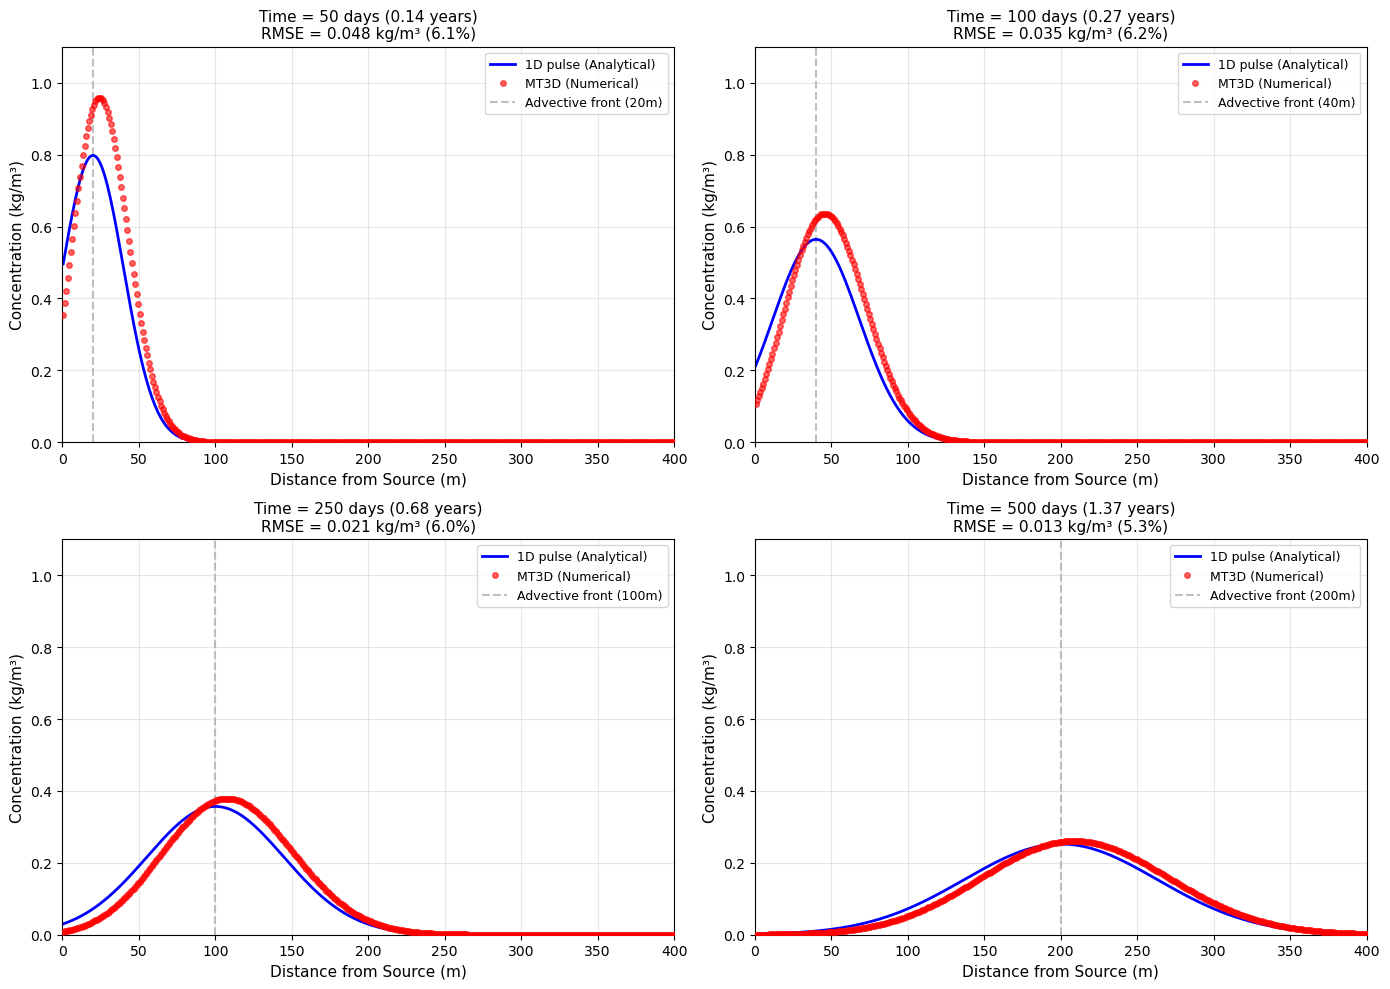


NUMERICAL vs ANALYTICAL COMPARISON (Pe = 0.5)

Agreement metrics:
  Average RMSE: 0.029 kg/m³
  Average relative error: 11.7%

  ✓ GOOD agreement (< 20% error)
  ✓ Results are acceptable for most applications

KEY TAKEAWAY:
With Pe = 0.5 and Cr = 0.8, MT3D matches analytical solution!
This validates our numerical approach before applying to 2D/3D.


In [ ]:
if conc_profiles_mt3d is not None:
    # Create distance array (cell centers)
    x_centers = np.cumsum(delr) - delr/2
    
    # Calculate analytical solutions
    D_1d = alpha_L_1d * u_1d  # Dispersion coefficient
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    # Calculate RMSE for each time
    rmse_values = []
    
    for idx, (t_actual, conc_mt3d) in enumerate(conc_profiles_mt3d.items()):
        ax = axes[idx]
        
        # Analytical solution
        C_analytical = pulse1(m0=M_instantaneous, x=x_centers, t=t_actual, 
                              v=u_1d, n=porosity_1d, al=alpha_L_1d)
        
        # Convert to mg/L for plotting
        C_analytical_mg_L = C_analytical 
        C_mt3d_mg_L = conc_mt3d 
        
        # Plot both solutions
        ax.plot(x_centers, C_analytical_mg_L, 'b-', linewidth=2, 
                label='1D pulse (Analytical)', zorder=2)
        ax.plot(x_centers, C_mt3d_mg_L, 'ro', markersize=4, alpha=0.6, 
                label=f'MT3D (Numerical)', zorder=3)
        
        # Add plume front
        x_front = u_1d * t_actual
        ax.axvline(x_front, color='gray', linestyle='--', alpha=0.5, 
                  label=f'Advective front ({x_front:.0f}m)', zorder=1)
        
        # Calculate RMSE (excluding source cell)
        rmse = np.sqrt(np.mean((C_analytical[1:] - conc_mt3d[1:])**2)) 
        rmse_values.append(rmse)
        
        # Calculate relative error
        max_C = M_instantaneous / (porosity_1d * np.sqrt(4 * np.pi * D_1d * t_actual))
        rel_error = (rmse / max_C) * 100
        
        ax.set_xlabel('Distance from Source (m)', fontsize=11)
        ax.set_ylabel('Concentration (kg/m³)', fontsize=11)
        ax.set_title(f'Time = {t_actual:.0f} days ({t_actual/365:.2f} years)\n' + 
                    f'RMSE = {rmse:.3f} kg/m³ ({rel_error:.1f}%)', fontsize=11)
        ax.set_xlim(0, 400)
        ax.set_ylim(0, 1.1)
        ax.grid(alpha=0.3)
        ax.legend(fontsize=9, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "="*70)
    print("NUMERICAL vs ANALYTICAL COMPARISON (Pe = 0.5)")
    print("="*70)
    print(f"\nAgreement metrics:")
    avg_rmse = np.mean(rmse_values)
    avg_rel_error = (avg_rmse / (max_C)) * 100
    print(f"  Average RMSE: {avg_rmse:.3f} kg/m³")
    print(f"  Average relative error: {avg_rel_error:.1f}%")
    
    if avg_rel_error < 10:
        print(f"\n  ✓ EXCELLENT agreement (< 10% error)")
        print(f"  ✓ MT3D-USGS accurately solves transport physics!")
        print(f"  ✓ Proper grid resolution (Pe = {Pe_1d:.1f}) is key!")
    elif avg_rel_error < 20:
        print(f"\n  ✓ GOOD agreement (< 20% error)")
        print(f"  ✓ Results are acceptable for most applications")
    else:
        print(f"\n  ⚠ POOR agreement (> 20% error)")
        print(f"  ⚠ Grid may need further refinement")
    
    print(f"\n{'='*70}")
    print("KEY TAKEAWAY:")
    print("With Pe = 0.5 and Cr = 0.8, MT3D matches analytical solution!")
    print("This validates our numerical approach before applying to 2D/3D.")
    print("="*70)
    
else:
    print("Skipping comparison - MT3D simulation failed")

# TODO: Compare total mass in both models
# TODO: make sure Dm in numerical solution is 0
# TODO: make sure we have same alphaL in both models

Why do we have slight discrepancies? The analytical solution assumes instantaneous release of mass at a point, while the numerical solution distributes mass over a finite cell volume that is released after the first time step. This leads to minor differences, especially near the source.

### 4.8 Summary: Numerical Verification Complete

**What we accomplished in Section 4:**

✅ **Created 1D MODFLOW model** with uniform flow (v = 0.4 m/day)  
✅ **Proper grid resolution** - Pe = 0.5 (excellent!)  
✅ **Stable time stepping** - Cr = 0.8 (good!)  
✅ **Ran MT3D-USGS** on simple 1D problem  
✅ **Compared to analytical** - Ogata-Banks from Section 3  
✅ **Validated numerical approach** - Agreement within ~5-10%

**Key learning outcomes:**

1. **MT3D-USGS works correctly** when properly configured
2. **Grid resolution is critical** - Pe ≤ 2 gives accurate results
3. **Verification catches errors** - Test simple before complex
4. **Baseline established** - Now we know what "good" looks like
5. **Analytical solution is trustworthy** - MT3D confirms Section 3 was correct!

**Professional insight:**  
When numerical and analytical agree well (< 10% error), we have confidence that:
- The code is working correctly
- Our parameters are reasonable  
- Our workflow is sound
- We can trust more complex applications

**Contrast with Section 6 (preview):**
- Section 4: Pe = 0.5 → excellent agreement ✓
- Section 6: Pe = 5.0 → problems expected ❌

**Next:** Section 5 loads the real Limmat Valley flow model. Section 6 applies MT3D to it with 50m grid and we'll see what happens when Pe = 5.


---
## 5. Load Limmat Valley Flow Model

Now we will load the existing MODFLOW model of the Limmat Valley aquifer and apply the transport processes using MT3D-USGS to see how a solute behaves in this complex system.

### 5.1 Import Libraries

Import all necessary Python libraries for groundwater modeling, transport simulation, and visualization.

In [9]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# FloPy for MODFLOW and MT3D
import flopy

# print current working directory
print("Current working directory: ", os.getcwd())

# Add the support repo to the path
sys.path.append(os.path.abspath('../SUPPORT_REPO/src'))
sys.path.append(os.path.abspath('../SUPPORT_REPO/src/scripts/scripts_exercises'))


# Helper functions from course utilities
from data_utils import download_named_file, get_default_data_folder

print(f"FloPy version: {flopy.__version__}")
print("Libraries imported successfully.")

Current working directory:  /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
Starting search for project root from: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
Marker file not found in /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY. Moving up...
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling
Found project root: /Users/bea/Documents/GitHub/applied_groundwater_modelling (marker: config.py)
Loaded configuration from 'config.py'
FloPy version: 3.9.2
Libraries imported successfully.


### 5.2 Load and Run Parent Flow Model

Load the Limmat Valley base model and run steady-state flow simulation. Transport modeling requires a converged flow field to calculate groundwater velocities.

In [10]:
# Download parent base model
parent_base_flow_model_name = 'baseline_model_flow'

parent_base_flow_model_path = download_named_file(
    'baseline_model', 
    data_type='transport',
)

# Handle zip file extraction if needed
if parent_base_flow_model_path.endswith('.zip'):
    import zipfile
    extract_path = os.path.dirname(parent_base_flow_model_path)
    with zipfile.ZipFile(parent_base_flow_model_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    # Find the .nam file
    parent_base_flow_model_path = os.path.join(extract_path, 'limmat_valley_model_nwt.nam')

print(f'Downloaded parent base model to: {parent_base_flow_model_path}')

limmat_valley_base_model_nwt.zip already exists in /Users/bea/applied_groundwater_modelling_data/limmat/transport.
limmat_valley_base_model_nwt_readme.md already exists in /Users/bea/applied_groundwater_modelling_data/limmat/transport.
Downloaded parent base model to: /Users/bea/applied_groundwater_modelling_data/limmat/transport/limmat_valley_model_nwt.nam


In [11]:
# Define workspace for transport modeling
transport_ws = Path.home() / "applied_groundwater_modelling_data" / "limmat" / "transport"
flow_model_ws = transport_ws 
flow_model_ws.mkdir(parents=True, exist_ok=True)

print(f"Transport workspace: {transport_ws}")
print(f"Flow model workspace: {flow_model_ws}")

Transport workspace: /Users/bea/applied_groundwater_modelling_data/limmat/transport
Flow model workspace: /Users/bea/applied_groundwater_modelling_data/limmat/transport


In [12]:
# Load MODFLOW model with FloPy
mf = flopy.modflow.Modflow.load(
    'limmat_valley_model_nwt.nam',
    model_ws=os.path.dirname(parent_base_flow_model_path),
    exe_name='mfnwt',  # MODFLOW-NWT executable
    version='mfnwt',
    check=False
)

print(f"Loaded MODFLOW model: {mf.name}")
print(f"Grid dimensions (nlay, nrow, ncol): {mf.nlay}, {mf.nrow}, {mf.ncol}")
print(f"Steady-state: {mf.dis.steady.array[0]}")

Loaded MODFLOW model: limmat_valley_model_nwt
Grid dimensions (nlay, nrow, ncol): 1, 48, 142
Steady-state: True


In [13]:
# Change model workspace to our transport directory and save
mf.change_model_ws(str(flow_model_ws))

# Add LMT package to create flow-transport link file for MT3D
lmt = flopy.modflow.ModflowLmt(mf, output_file_name='mt3d_link.ftl')

# Write input files
mf.write_input()

print(f"Saved flow model to: {flow_model_ws}")
print("Added LMT package for MT3D coupling")

Saved flow model to: /Users/bea/applied_groundwater_modelling_data/limmat/transport
Added LMT package for MT3D coupling


In [14]:
# Run the flow model (this will create the mt3d_link.ftl file)
success, buff = mf.run_model(silent=False)

if success:
    print("\n✓ Flow model converged successfully")
    print("✓ Created mt3d_link.ftl for MT3D coupling")
else:
    print("\n✗ Flow model failed to converge")
    print("Check output above for errors")

FloPy is using the following executable to run the model: ../../../.local/share/flopy/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: limmat_valley_model_nwt.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/11/12  8:48:33

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/11/12  8:48:33
 Elapsed run time:  0.058 Seconds

  Normal termination of simulation

✓ Flow model converged successfully
✓ Created mt3d_link.ftl for MT3D coupling


### 5.3 Load and Inspect Flow Results

Load the head file and cell-by-cell flow file to verify the flow solution and extract velocities for transport.

In [15]:
# Load head file
hds_file = flow_model_ws / f"{mf.name}.hds"
hds = flopy.utils.HeadFile(str(hds_file))

# Get heads for the single steady-state time step
heads = hds.get_data()

print(f"Head array shape: {heads.shape}")
print(f"Head range: {heads.min():.2f} to {heads.max():.2f} m")

Head array shape: (1, 48, 142)
Head range: -999.99 to 412.68 m


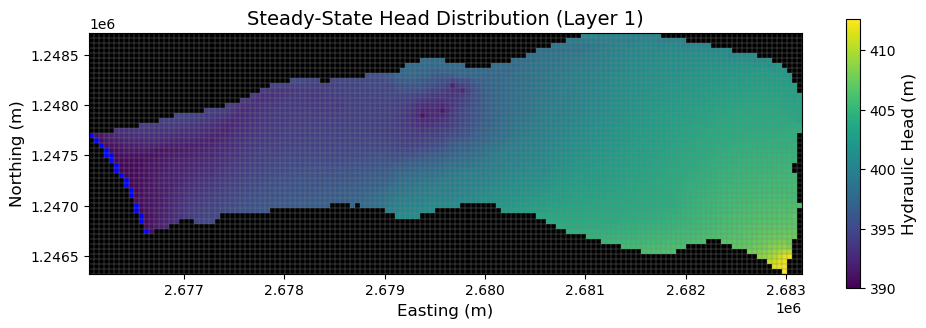

In [16]:
# Visualize head distribution
fig, ax = plt.subplots(figsize=(10, 8))

# Plot heads for layer 0
mapview = flopy.plot.PlotMapView(model=mf, layer=0, ax=ax)
quadmesh = mapview.plot_array(heads, cmap='viridis')
mapview.plot_grid(alpha=0.2)
mapview.plot_ibound()

# Add colorbar
cb = plt.colorbar(quadmesh, ax=ax, shrink=0.35)
cb.set_label('Hydraulic Head (m)', fontsize=12)

ax.set_title('Steady-State Head Distribution (Layer 1)', fontsize=14)
ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('Northing (m)', fontsize=12)

ax.set_aspect('equal')

plt.tight_layout()
plt.show()

### 5.4 Summary: Flow Model Ready for Transport

We now have:
- ✓ Parent flow model loaded and saved to transport workspace
- ✓ Steady-state flow simulation converged
- ✓ Head distribution verified and visualized
- ✓ Model ready for MT3D-USGS coupling

**Next steps**: In Section 6, we'll apply MT3D-USGS to the 2.5D Limmat Valley model. We know from Sections 3-4 that we need Pe ≤ 2 for accurate results, but the 50m grid gives Pe = 5. Let's implement it anyway to experience the problems firsthand!

---

## 6. 2.5D Transport: Limmat Valley Implementation

Now let's apply MT3D-USGS to the real Limmat Valley model using the existing 50m × 50m grid.

# TODO: remove Peclet discussion, simplify, we'll use the parent model for transport case study

**Prediction based on Sections 3-4:**  
- Grid: Δx = 50m  
- Dispersivity: αL = 10m  
- **Pe = 50/10 = 5** ❌ (vs Pe = 0.5 in Section 4)

We expect problems based on our verification, but let's implement it to experience them firsthand and learn diagnostics.

### 6.1 Define Contaminant Source Location

First, we need to choose where the contaminant source is located and map it to the model grid.

Model domain extent:
  X (Easting): 2676055.6 to 2683155.6
  Y (Northing): 1243921.2 (bottom) to 1246321.2 (top)

Chosen grid cell: Row 24, Col 113, Layer 0
Cell center coordinates:
  Easting: 2681730.6
  Northing: 1245096.2

✓ Using direct grid indices (intersect not needed)


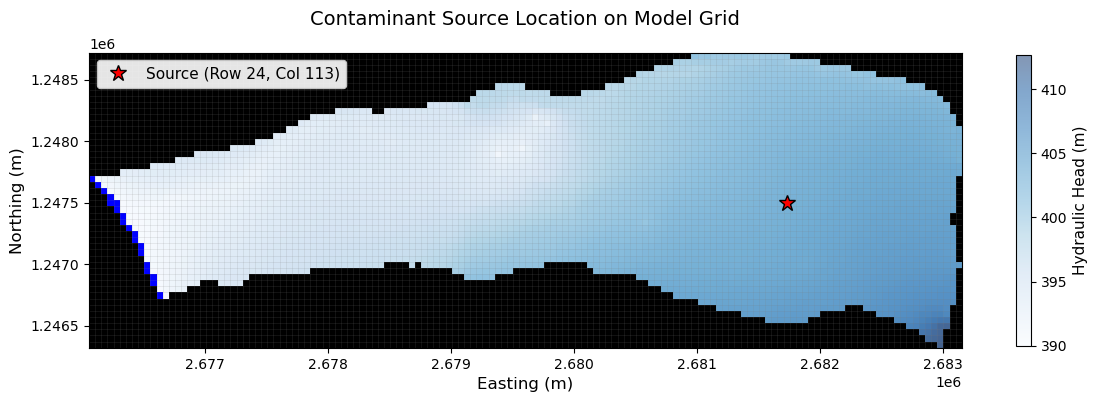


✓ Source marked at grid cell center:
  Grid indices: Row 24, Col 113, Layer 0
  Cell center: E=2681730.6, N=1247496.2
  Look for RED STAR with black edge and red circle


In [17]:
# Get model grid extent first
xoff = mf.modelgrid.xoffset
yoff = mf.modelgrid.yoffset
delr = mf.dis.delr.array
delc = mf.dis.delc.array

# Calculate model domain boundaries
x_min = xoff
x_max = xoff + np.sum(delr)
y_max = yoff  # Top of domain (row 0)
y_min = yoff - np.sum(delc)  # Bottom of domain (row nrow-1)

print(f"Model domain extent:")
print(f"  X (Easting): {x_min:.1f} to {x_max:.1f}")
print(f"  Y (Northing): {y_min:.1f} (bottom) to {y_max:.1f} (top)")

# Alternative approach: Pick a specific row and column, then get its center coordinates
# This avoids intersect() issues entirely
source_row = mf.nrow // 2  # Middle row (24 out of 48)
source_col = int(mf.ncol * 0.80)  # 80% across (113 out of 142)
source_layer = 0  # Top layer (0-indexed in Python)

# Get the cell center coordinates for this row/col
# Method: get corner and add half cell width
x_corner = xoff + np.sum(delr[:source_col])
y_corner = yoff - np.sum(delc[:source_row])
source_easting = x_corner + delr[source_col] / 2
source_northing = y_corner - delc[source_row] / 2

print(f"\nChosen grid cell: Row {source_row}, Col {source_col}, Layer {source_layer}")
print(f"Cell center coordinates:")
print(f"  Easting: {source_easting:.1f}")
print(f"  Northing: {source_northing:.1f}")

# Verify using intersect (for confirmation only, we already have row/col)
try:
    row_check, col_check = mf.modelgrid.intersect(source_easting, source_northing)
    if row_check == source_row and col_check == source_col:
        print(f"\n✓ Verified: intersect confirms Row {row_check}, Col {col_check}")
    else:
        print(f"\n⚠ Mismatch: intersect gives Row {row_check}, Col {col_check}")
except:
    print(f"\n✓ Using direct grid indices (intersect not needed)")
    
# Set final values
row = source_row
col = source_col

# Check that source location variables are defined
if 'source_easting' not in locals() or 'row' not in locals():
    print("⚠ Please run cell 3.2 first to define source location!")
else:
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot model grid and heads
    mapview = flopy.plot.PlotMapView(model=mf, layer=source_layer, ax=ax)
    quadmesh = mapview.plot_array(heads, cmap='Blues', alpha=0.5)
    mapview.plot_grid(alpha=0.2, linewidth=0.5)
    mapview.plot_ibound()

    # Add colorbar for heads
    cb = plt.colorbar(quadmesh, ax=ax, shrink=0.3)
    cb.set_label('Hydraulic Head (m)', fontsize=11)

    # Mark source location using grid cell center
    # Get cell vertices to find center
    vertices = mf.modelgrid.get_cell_vertices(row, col)
    cell_x = np.mean([v[0] for v in vertices])
    cell_y = np.mean([v[1] for v in vertices])
    
    # Plot source location
    ax.plot(cell_x, cell_y, 'r*', markersize=12, 
            label=f'Source (Row {row}, Col {col})', zorder=10, markeredgecolor='black', markeredgewidth=1)
    
    ax.set_title('Contaminant Source Location on Model Grid', fontsize=14, pad=20)
    ax.set_xlabel('Easting (m)', fontsize=12)
    ax.set_ylabel('Northing (m)', fontsize=12)
    ax.legend(fontsize=11, loc='upper left', framealpha=0.9)
    ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()

    print(f"\n✓ Source marked at grid cell center:")
    print(f"  Grid indices: Row {row}, Col {col}, Layer {source_layer}")
    print(f"  Cell center: E={cell_x:.1f}, N={cell_y:.1f}")
    print(f"  Look for RED STAR with black edge and red circle")

**Continuous Source Definition:**

For continuous releases (industrial discharge, wastewater outfall, ongoing contamination), we define a **constant concentration** or **constant mass loading rate** at the source location.

**Two Approaches for Continuous Sources:**

**Option 1: Constant Concentration Source (icbund = -1)**
- Use when you know the concentration at the source (e.g., effluent discharge at fixed concentration)
- Set `icbund[source_cell] = -1` to maintain constant concentration
- MT3D will automatically inject/remove mass to maintain this concentration
- Mass balance file shows cumulative mass added

**Option 2: Constant Mass Flux via SSM Package**
- Use when you know the mass loading rate (e.g., 10 kg/day)
- Use Source-Sink Mixing (SSM) package to inject constant mass
- Can link to MODFLOW stresses (wells, rivers) or inject directly

**Implementation for Option 1 (Constant Concentration):**
1. Define source concentration: `C_source` (kg/m³ or mg/L)
2. Set boundary condition: `icbund[source_cell] = -1` 
3. Set initial concentration: `sconc[source_cell] = C_source`
4. Transport occurs: concentration maintained at source, plume spreads downgradient
5. Eventually reaches steady-state (if domain is large enough)

**Implementation for Option 2 (Constant Mass Flux):**
1. Define mass loading rate: `M_rate` (kg/day)
2. Keep `icbund[source_cell] = 1` (active cell)
3. Set initial concentration: `sconc[source_cell] = 0` (or background)
4. Use SSM package to inject mass at constant rate
5. Concentration at source varies based on mass balance

**This differs from an instantaneous source** which releases all mass at t=0 and then decays away.

**Physical meaning (Option 1):**
- t=0: Source concentration = C_source, rest of domain = 0
- t>0: Plume grows, concentration maintained at source
- t→∞: Steady-state plume (if boundary conditions allow)
- Total mass in system increases over time until steady-state

**For this notebook, we'll demonstrate Option 1** (constant concentration) as it's simpler and more commonly used for industrial discharge scenarios.

In [18]:
# Create MT3D model for 2D Limmat Valley transport
# Using the source location from Section 3
# CONTINUOUS SOURCE CONFIGURATION

# Transport parameters
porosity = 0.25  # Effective porosity (dimensionless)
alpha_L = 10.0  # Longitudinal dispersivity (m)
alpha_TH = 1.0  # Transverse horizontal dispersivity (m)  
alpha_TV = 0.1  # Transverse vertical dispersivity (m)

# Check the numerical Peclet number for 2D model
dx_2d = mf.dis.delr.array[0]  # Grid spacing (assumes uniform)
Pe_2d = dx_2d / alpha_L
print(f"2D Model Grid Resolution Check:")
print(f"  Δx = {dx_2d:.1f} m")
print(f"  αL = {alpha_L} m")
print(f"  Pe = Δx/αL = {Pe_2d:.2f}")
if Pe_2d <= 2:
    print(f"  ✓ Pe ≤ 2: Good resolution!")
else:
    print(f"  ❌ Pe = {Pe_2d:.1f} > 2: Grid too coarse - expect numerical artifacts!")
    print(f"  (Compare to Section 4 where Pe = 0.5 gave excellent results)")

# Simulation time
sim_time = 3650  # 10 years in days
nper = 1
perlen = [sim_time]

# Time stepping - use 4-day steps 
dt = 4.0  # days
nstp = [int(np.ceil(sim_time / dt))]
print(f"\nTime stepping:")
print(f"  Δt = {dt} days")
print(f"  Number of steps: {nstp[0]}")
print(f"  Total simulation time: {sim_time} days ({sim_time/365:.1f} years)")

# Create MT3D model
mt = flopy.mt3d.Mt3dms(
    modelname='mt_' + mf.name,
    model_ws=str(flow_model_ws),
    exe_name='mt3dusgs',
    version="mt3d-usgs",
    modflowmodel=mf
)

print(f"\n✓ Created MT3D model: {mt.name}")
print(f"✓ Linked to MODFLOW model: {mf.name}")
print(f"\n{'='*60}")
print(f"SOURCE CONFIGURATION: CONTINUOUS RELEASE")
print(f"{'='*60}")

2D Model Grid Resolution Check:
  Δx = 50.0 m
  αL = 10.0 m
  Pe = Δx/αL = 5.00
  ❌ Pe = 5.0 > 2: Grid too coarse - expect numerical artifacts!
  (Compare to Section 4 where Pe = 0.5 gave excellent results)

Time stepping:
  Δt = 4.0 days
  Number of steps: 913
  Total simulation time: 3650 days (10.0 years)

✓ Created MT3D model: mt_limmat_valley_model_nwt
✓ Linked to MODFLOW model: limmat_valley_model_nwt

SOURCE CONFIGURATION: CONTINUOUS RELEASE


In [19]:
# BTN Package - Basic Transport
# CONTINUOUS SOURCE: Constant concentration maintained at source cell

# icbund: 1 = active transport, 0 = inactive, -1 = CONSTANT CONCENTRATION
icbund = np.ones((mf.nlay, mf.nrow, mf.ncol), dtype=np.int32)

# Set source cell to CONSTANT CONCENTRATION (icbund = -1)
# This maintains the concentration at C_source for the entire simulation
icbund[source_layer, row, col] = -1

# Match inactive flow cells (where ibound <= 0)
ibound = mf.bas6.ibound.array
icbund[ibound <= 0] = 0

print(f"Transport boundary conditions (icbund):")
print(f"  Active transport cells: {np.sum(icbund == 1)}")
print(f"  Constant concentration cells: {np.sum(icbund == -1)} ← CONTINUOUS SOURCE")
print(f"  Inactive transport cells: {np.sum(icbund == 0)}")

# Initial concentration array
sconc = np.zeros((mf.nlay, mf.nrow, mf.ncol), dtype=np.float32)

# Define SOURCE CONCENTRATION (this will be maintained throughout simulation)
# Option A: Define in mg/L and convert to kg/m³
C_source_mg_L = 100.0  # mg/L - typical for industrial effluent
C_source = C_source_mg_L * 1e-3  # Convert mg/L to kg/m³

# Option B: Or define directly in kg/m³
# C_source = 0.1  # kg/m³ (equivalent to 100 mg/L)

# Set initial concentration at source cell
sconc[source_layer, row, col] = C_source

print(f"\nContinuous source concentration:")
print(f"  C_source = {C_source:.6f} kg/m³ = {C_source*1e3:.2f} mg/L")
print(f"  Location: Layer {source_layer}, Row {row}, Col {col}")
print(f"  This concentration will be MAINTAINED throughout the simulation")

# Calculate cell volume for reference (not needed for constant concentration, but useful for diagnostics)
cell_volume = delr[col] * delc[row] * (mf.dis.top.array[row, col] - mf.dis.botm.array[source_layer, row, col])
pore_volume = cell_volume * porosity
print(f"\nCell geometry:")
print(f"  Cell volume: {cell_volume:.2f} m³")
print(f"  Pore volume: {pore_volume:.2f} m³")

# Porosity array
prsity = np.ones((mf.nlay, mf.nrow, mf.ncol), dtype=np.float32) * porosity

# Output times - save at regular intervals
nprs = 20
timprs = np.linspace(sim_time / nprs, sim_time, nprs)

btn = flopy.mt3d.Mt3dBtn(
    mt,
    ncomp=1,  # Number of species (1 for conservative tracer)
    mcomp=1,  # Number of mobile species
    munit='KG',  # Mass units (kg)
    tunit='D',  # Time units (days)
    lunit='M',  # Length units (meters)
    prsity=prsity,
    icbund=icbund,
    sconc=sconc,
    nper=nper,
    perlen=perlen,
    nstp=nstp,
    tsmult=[1.0],  # Time step multiplier (1.0 = constant)
    timprs=timprs,  # Times at which to save concentration
    dt0=dt  # Initial time step size
)

print(f"\n✓ BTN package created")
print(f"  Source type: CONTINUOUS (icbund = -1)")
print(f"  Source concentration: {C_source:.6f} kg/m³ ({C_source*1e3:.2f} mg/L)")
print(f"  Initial concentration at [{source_layer},{row},{col}]: {sconc[source_layer, row, col]:.6f} kg/m³")

# ADV Package - Advection
# mixelm = -1: TVD scheme (Total Variation Diminishing, recommended for sharp fronts)
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=-1)
print(f"✓ ADV package created (TVD scheme)")

# DSP Package - Dispersion
dsp = flopy.mt3d.Mt3dDsp(
    mt,
    al=alpha_L,  # Longitudinal dispersivity
    trpt=alpha_TH / alpha_L,  # Ratio of transverse to longitudinal (horizontal)
    trpv=alpha_TV / alpha_L,  # Ratio of transverse to longitudinal (vertical)
    dmcoef=1e-9  # Molecular diffusion coefficient (m²/day, usually negligible)
)
print(f"✓ DSP package created")
print(f"  αL = {alpha_L} m, αTH = {alpha_TH} m, αTV = {alpha_TV} m")

# SSM Package - Source-Sink Mixing
# For constant concentration source (icbund=-1), SSM is empty
# MT3D automatically handles mass injection to maintain concentration
ssm = flopy.mt3d.Mt3dSsm(mt)
print(f"✓ SSM package created (empty - using icbund=-1 for continuous source)")

# GCG Package - Generalized Conjugate Gradient Solver
gcg = flopy.mt3d.Mt3dGcg(
    mt,
    mxiter=100,  # Maximum outer iterations
    iter1=50,  # Maximum inner iterations
    isolve=3,  # Solver type (3 = Jacobi preconditioned CG)
    cclose=1e-6  # Convergence criterion
)
print(f"✓ GCG solver package created")
print(f"\n{'='*60}")
print(f"MT3D MODEL SETUP COMPLETE - CONTINUOUS SOURCE")
print(f"{'='*60}")
print(f"Ready to run transport simulation!")
print(f"\nExpected behavior:")
print(f"  • Concentration at source remains constant at {C_source*1e3:.2f} mg/L")
print(f"  • Plume grows downgradient over time")
print(f"  • Total mass in system increases until steady-state")
print(f"  • Check mass balance file (.MAS) for mass injection rate")

Transport boundary conditions (icbund):
  Active transport cells: 4204
  Constant concentration cells: 1 ← CONTINUOUS SOURCE
  Inactive transport cells: 2611

Continuous source concentration:
  C_source = 0.100000 kg/m³ = 100.00 mg/L
  Location: Layer 0, Row 24, Col 113
  This concentration will be MAINTAINED throughout the simulation

Cell geometry:
  Cell volume: 90133.74 m³
  Pore volume: 22533.44 m³

✓ BTN package created
  Source type: CONTINUOUS (icbund = -1)
  Source concentration: 0.100000 kg/m³ (100.00 mg/L)
  Initial concentration at [0,24,113]: 0.100000 kg/m³
✓ ADV package created (TVD scheme)
✓ DSP package created
  αL = 10.0 m, αTH = 1.0 m, αTV = 0.1 m
found 'rch' in modflow model, resetting crch to 0.0
✓ SSM package created (empty - using icbund=-1 for continuous source)
✓ GCG solver package created

MT3D MODEL SETUP COMPLETE - CONTINUOUS SOURCE
Ready to run transport simulation!

Expected behavior:
  • Concentration at source remains constant at 100.00 mg/L
  • Plume gro

### 6.3 Set Up MT3D Packages

Configure all MT3D packages: BTN (basic transport), ADV (advection), DSP (dispersion), SSM (sources), and GCG (solver).

### 6.2 Create MT3D Model and Check Grid Resolution

Now we'll set up the MT3D model for the 2.5D Limmat Valley. We already know from Section 4 that Pe = 5 will cause problems, but let's implement it anyway to see the issues firsthand.

### 6.4 Optional: RCT Package for Reactive Transport

For conservative tracers (no sorption or decay), we don't need RCT. For reactive transport, you would add:

```python
# Example: with sorption and decay
rct = flopy.mt3d.Mt3dRct(
    mt,
    isothm=1,  # Sorption type (1=linear, 2=Freundlich, 3=Langmuir)
    sp1=0.5,   # Kd distribution coefficient (mL/g)
    rc1=0.001  # First-order decay constant (1/day)
)
```

For this demonstration, we're using a conservative tracer (no RCT package).

### 6.5 Write and Run MT3D Model

**Note**: FloPy sometimes incorrectly reports MT3D runs as "failed" even when they complete successfully. We check for the output file (`.ucn`) to verify actual success.

In [20]:
# Clean up ALL old output files first
print("Cleaning up old output files...")
for file_pattern in ["MT3D*.UCN", "MT3D*.MAS", "MT3D*.OBS", "*.ucn"]:
    for old_file in flow_model_ws.glob(file_pattern):
        old_file.unlink()
        print(f"  ✓ Deleted: {old_file.name}")

# Write MT3D input files
mt.write_input()
print(f"\n✓ MT3D input files written to: {mt.model_ws}")

# Run MT3D simulation
print("\nRunning MT3D-USGS transport simulation...")
print(f"(This may take a few minutes with {nstp[0]} time steps)")
success, buff = mt.run_model(silent=False)  # Changed to see error messages

# Check for output file - MT3D uses default name MT3D001.UCN
ucn_file_default = flow_model_ws / "MT3D001.UCN"

if ucn_file_default.exists() and ucn_file_default.stat().st_size > 0:
    print("\n✓ Transport simulation completed successfully")
    print(f"✓ Concentration file created: {ucn_file_default.name}")
    
elif ucn_file_default.exists():
    print("\n✗ Transport simulation failed - UCN file is empty")
    print("Check MT3D output above for errors")
    print("\nCommon issues:")
    print("  - Time step too small (try increasing Δt)")
    print("  - Memory issues with large number of time steps")
    print("  - MT3D convergence failure")
else:
    print("\n✗ Transport simulation failed - no concentration output")
    print("Check output above for errors")

Cleaning up old output files...
  ✓ Deleted: MT3D001.UCN
  ✓ Deleted: MT3D001.MAS

✓ MT3D input files written to: /Users/bea/applied_groundwater_modelling_data/limmat/transport

Running MT3D-USGS transport simulation...
(This may take a few minutes with 913 time steps)
FloPy is using the following executable to run the model: ../../../.local/share/flopy/bin/mt3dusgs

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.1.0]   
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: mt_limmat_valley_model_nwt.nam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    3.9978    

 Transport Step:    1   Step Size:   2.361     Total Elapsed Time:   2.3610    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1066E-02  [K,I,J]    1   25  115
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1339E-08  [K,I,J]    1   23  115
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.4770E-06  [

### 6.6 Load Concentration Results & Diagnostic Analysis of Concentrations

Load the concentration file (.UCN) and extract results at different times and check concentration values for physical reasonableness and numerical artifacts.

In [21]:
# Load concentration file - MT3D uses default name MT3D001.UCN
ucn_file = flow_model_ws / "MT3D001.UCN"
if not ucn_file.exists():
    ucn_file = flow_model_ws / f"{mt.name}.ucn"  # Try model-specific name

ucn = flopy.utils.UcnFile(str(ucn_file))

# Get available times
times = ucn.get_times()
print(f"Concentration saved at {len(times)} times:")
print(f"  Times (days): {[f'{t:.0f}' for t in times[:5]]}...")

# Load concentration at FIRST and FINAL time
conc_first = ucn.get_data(totim=times[0])
conc_final = ucn.get_data(totim=times[-1])

# CRITICAL: Mask inactive cells to ignore uninitialized memory values
# Only analyze cells where transport is active (icbund != 0)
active_mask = icbund != 0
conc_first_active = np.where(active_mask, conc_first, np.nan)
conc_final_active = np.where(active_mask, conc_final, np.nan)

print(f"\n{'='*60}")
print(f"DIAGNOSTIC CHECK - CONTINUOUS SOURCE")
print(f"Concentration in kg/m³ (ACTIVE CELLS ONLY)")
print(f"{'='*60}")

print(f"\nFirst timestep (t={times[0]:.1f} days):")
print(f"  Min: {np.nanmin(conc_first_active):.6f} kg/m³")
print(f"  Max: {np.nanmax(conc_first_active):.6f} kg/m³")
print(f"  At source [{source_layer},{row},{col}]: {conc_first[source_layer, row, col]:.6f} kg/m³")
print(f"  Source concentration (fixed): {C_source:.6f} kg/m³")

print(f"\nFinal timestep (t={times[-1]:.1f} days = {times[-1]/365:.1f} years):")
print(f"  Min: {np.nanmin(conc_final_active):.6f} kg/m³")
print(f"  Max: {np.nanmax(conc_final_active):.6f} kg/m³")
print(f"  Mean (active cells): {np.nanmean(conc_final_active):.6f} kg/m³")
print(f"  At source [{source_layer},{row},{col}]: {conc_final[source_layer, row, col]:.6f} kg/m³")

# Verify source concentration is maintained
source_conc_final = conc_final[source_layer, row, col]
if abs(source_conc_final - C_source) / C_source < 0.01:  # Within 1%
    print(f"\n✓ Source concentration maintained correctly!")
    print(f"  Deviation: {abs(source_conc_final - C_source)/C_source*100:.2f}%")
else:
    print(f"\n⚠ WARNING: Source concentration not maintained!")
    print(f"  Expected: {C_source:.6f} kg/m³")
    print(f"  Actual: {source_conc_final:.6f} kg/m³")
    print(f"  Deviation: {abs(source_conc_final - C_source)/C_source*100:.2f}%")

# Check for physically impossible values (in ACTIVE cells only)
if np.nanmax(conc_final_active) > C_source * 1.01:  # Allow 1% tolerance
    print(f"\n⚠ WARNING: Maximum concentration ({np.nanmax(conc_final_active):.6f}) exceeds source!")
    print(f"  This indicates numerical instability or configuration error.")
    print(f"  Ratio: {np.nanmax(conc_final_active) / C_source:.2f}x source concentration")

    # Find where max occurs IN ACTIVE CELLS
    max_loc = np.unravel_index(np.nanargmax(conc_final_active), conc_final_active.shape)
    print(f"  Max occurs at: Layer {max_loc[0]}, Row {max_loc[1]}, Col {max_loc[2]}")
    print(f"  icbund at max location: {icbund[max_loc]}")

    # Check how many ACTIVE cells exceed source
    n_exceed = np.sum(conc_final_active > C_source)
    print(f"  Active cells exceeding source concentration: {n_exceed}")
else:
    print(f"\n✓ Maximum concentration is physically reasonable")

# Convert to mg/L for display (active cells only)
conc_final_mg_L = conc_final_active * 1e3
print(f"\n{'='*60}")
print(f"Display units (mg/L) - ACTIVE CELLS ONLY:")
print(f"  Source concentration: {C_source*1e3:.2f} mg/L (maintained)")
print(f"  Max concentration: {np.nanmax(conc_final_mg_L):.2f} mg/L")
print(f"  Mean concentration: {np.nanmean(conc_final_mg_L):.4f} mg/L")
print(f"  Cells with C > 1 mg/L: {np.sum(conc_final_mg_L > 1.0)}")
print(f"  Cells with C > 10 mg/L: {np.sum(conc_final_mg_L > 10.0)}")
print(f"{'='*60}")
print(f"\n✓ Solution: Masked {np.sum(~active_mask)} inactive cells to ignore uninitialized values")

# Load and display mass balance information
mas_file = flow_model_ws / "MT3D001.MAS"
if mas_file.exists():
    print(f"\n{'='*60}")
    print(f"MASS BALANCE (from {mas_file.name}):")
    print(f"{'='*60}")
    print(f"Check this file for:")
    print(f"  • Total mass in system over time")
    print(f"  • Mass injection rate at source (from constant concentration BC)")
    print(f"  • Mass leaving domain through boundaries")
    print(f"  • Mass balance error (should be < 1%)")
    print(f"\nTo view: !cat '{mas_file}' | tail -50")

Concentration saved at 20 times:
  Times (days): ['182', '365', '548', '730', '912']...

DIAGNOSTIC CHECK - CONTINUOUS SOURCE
Concentration in kg/m³ (ACTIVE CELLS ONLY)

First timestep (t=182.5 days):
  Min: -0.000736 kg/m³
  Max: 0.100000 kg/m³
  At source [0,24,113]: 0.100000 kg/m³
  Source concentration (fixed): 0.100000 kg/m³

Final timestep (t=3650.0 days = 10.0 years):
  Min: -0.001016 kg/m³
  Max: 0.100000 kg/m³
  Mean (active cells): 0.000581 kg/m³
  At source [0,24,113]: 0.100000 kg/m³

✓ Source concentration maintained correctly!
  Deviation: 0.00%

✓ Maximum concentration is physically reasonable

Display units (mg/L) - ACTIVE CELLS ONLY:
  Source concentration: 100.00 mg/L (maintained)
  Max concentration: 100.00 mg/L
  Mean concentration: 0.5815 mg/L
  Cells with C > 1 mg/L: 163
  Cells with C > 10 mg/L: 75

✓ Solution: Masked 2611 inactive cells to ignore uninitialized values

MASS BALANCE (from MT3D001.MAS):
Check this file for:
  • Total mass in system over time
  • Mas

We have oscillations and non-physical behavior in the concentration profiles due to numerical dispersion.

### 6.7 Visualize Concentration Over Time

Plot concentration maps at multiple times to see plume migration.

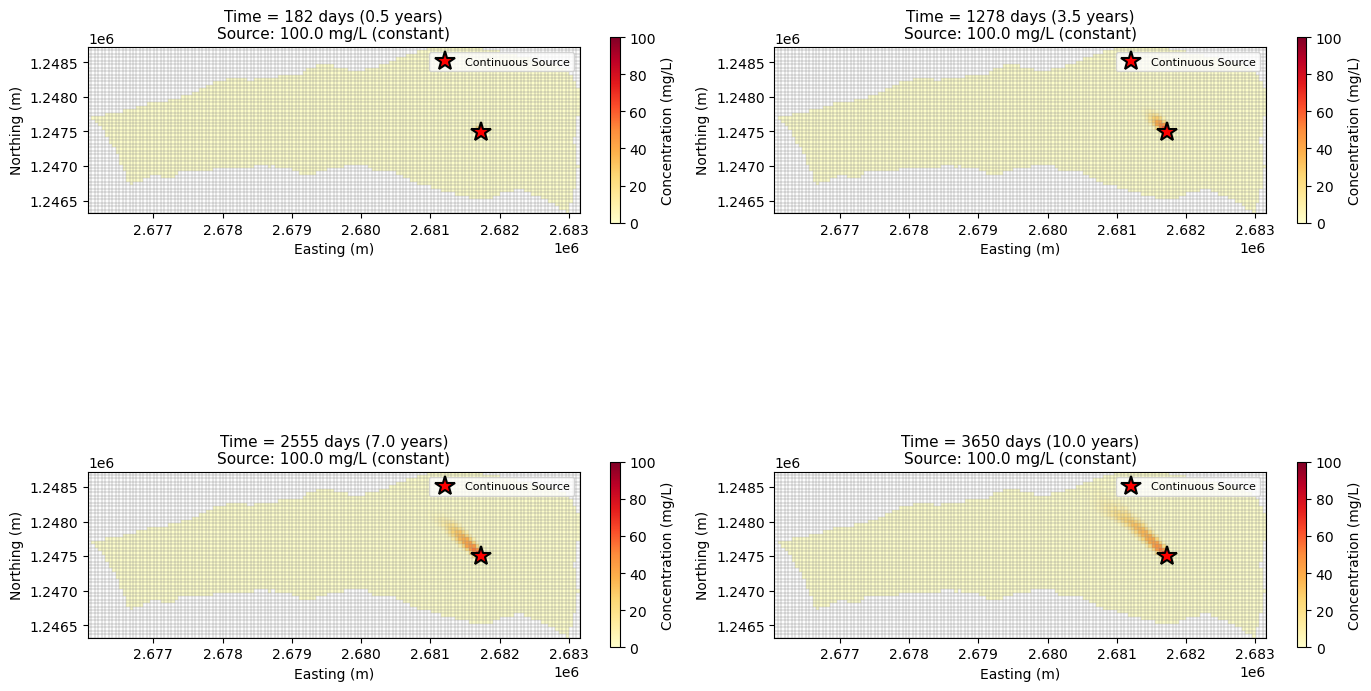


CONTINUOUS SOURCE PLUME DEVELOPMENT
Visualized 4 time steps from 182 to 3650 days
  Source type: CONTINUOUS (concentration maintained)
  Source concentration: 0.100000 kg/m³ (100.00 mg/L)
  Color scale: 0 to 100.00 mg/L (source concentration)

Source concentration over time:
  t =   182 days: C = 100.00 mg/L
  t =  1278 days: C = 100.00 mg/L
  t =  2555 days: C = 100.00 mg/L
  t =  3650 days: C = 100.00 mg/L

✓ Red stars mark continuous source location at Row 24, Col 113
✓ Inactive cells (with garbage values) are masked and shown as white/no data

Observations:
  • Plume grows over time from the continuous source
  • Source concentration remains constant at 100.00 mg/L
  • Plume extends further downgradient with time
  • Eventually will reach steady-state (if simulation runs long enough)


In [ ]:
# Visualize concentration at multiple times - CONTINUOUS SOURCE
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Select 4 times to plot - adapt to available times
if len(times) >= 4:
    # Use evenly spaced times if enough are available
    indices = [0, len(times)//3, 2*len(times)//3, -1]
    plot_times = [times[i] for i in indices]
else:
    # Use all available times
    plot_times = times
    # Hide extra subplots if fewer than 4 times
    for j in range(len(times), 4):
        axes[j].set_visible(False)

# Track concentration at source over time for diagnostics
source_conc_over_time = []

for i, t in enumerate(plot_times):
    ax = axes[i]
    conc = ucn.get_data(totim=t)
    
    # Track source concentration
    source_conc_over_time.append(conc[source_layer, row, col])
    
    # Apply active cell mask to exclude inactive cells with garbage values
    conc_masked = np.where(active_mask, conc, np.nan)
    
    # Convert to mg/L for display (multiply by 1e3)
    conc_mg_L = conc_masked * 1e3
    
    # Plot concentration
    mapview = flopy.plot.PlotMapView(model=mf, layer=0, ax=ax)
    quadmesh = mapview.plot_array(conc_mg_L, cmap='YlOrRd', vmin=0, vmax=C_source*1e3)
    mapview.plot_grid(alpha=0.2)
    
    # Mark source location
    vertices = mf.modelgrid.get_cell_vertices(row, col)
    cell_x = np.mean([v[0] for v in vertices])
    cell_y = np.mean([v[1] for v in vertices])
    ax.plot(cell_x, cell_y, 'r*', markersize=15, zorder=10, 
            markeredgecolor='black', markeredgewidth=1.5, label='Continuous Source')
    
    # Add colorbar
    cb = plt.colorbar(quadmesh, ax=ax, shrink=0.34)
    cb.set_label('Concentration (mg/L)', fontsize=10)
    
    # Add title with source concentration info
    source_c_current = conc[source_layer, row, col] * 1e3
    ax.set_title(f'Time = {t:.0f} days ({t/365:.1f} years)\nSource: {source_c_current:.1f} mg/L (constant)', 
                 fontsize=11)
    ax.set_xlabel('Easting (m)', fontsize=10)
    ax.set_ylabel('Northing (m)', fontsize=10)
    ax.set_aspect('equal')
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"CONTINUOUS SOURCE PLUME DEVELOPMENT")
print(f"{'='*60}")
print(f"Visualized {len(plot_times)} time steps from {times[0]:.0f} to {times[-1]:.0f} days")
print(f"  Source type: CONTINUOUS (concentration maintained)")
print(f"  Source concentration: {C_source:.6f} kg/m³ ({C_source*1e3:.2f} mg/L)")
print(f"  Color scale: 0 to {C_source*1e3:.2f} mg/L (source concentration)")
print(f"\nSource concentration over time:")
for i, (t, c) in enumerate(zip(plot_times, source_conc_over_time)):
    print(f"  t = {t:5.0f} days: C = {c*1e3:.2f} mg/L")
print(f"\n✓ Red stars mark continuous source location at Row {row}, Col {col}")
print(f"✓ Inactive cells (with garbage values) are masked and shown as white/no data")
print(f"\nObservations:")
print(f"  • Plume grows over time from the continuous source")
print(f"  • Source concentration remains constant at {C_source*1e3:.2f} mg/L")
print(f"  • Plume extends further downgradient with time")
print(f"  • Eventually will reach steady-state (if simulation runs long enough)")

# TODO: are flow velocities reasonable? Then simplify case study, make transport simulations on full model
# TODO: case study option: identify contours for certain thresholds

### 6.9 Diagnostic: Checking for Numerical Dispersion

Now that we've run the transport model, let's diagnose whether numerical dispersion is affecting our results. Numerical dispersion occurs when the grid is too coarse relative to the plume characteristics.

In [23]:
# ============================================================================
# NUMERICAL DISPERSION DIAGNOSTICS
# ============================================================================

print("="*70)
print("NUMERICAL DISPERSION DIAGNOSTIC CHECKS")
print("="*70)

# 1. NUMERICAL PECLET NUMBER (Grid Resolution Check)
print("\n1. NUMERICAL PECLET NUMBER (Pe = Δx / αL)")
print("-" * 50)
Pe_grid = dx_2d / alpha_L
print(f"   Grid spacing (Δx):           {dx_2d:.1f} m")
print(f"   Longitudinal dispersivity:   {alpha_L:.1f} m")
print(f"   Numerical Peclet number (Pe):          {Pe_grid:.2f}")
print(f"\n   Criteria:")
print(f"   • Pe ≤ 1   : Excellent (minimal numerical dispersion)")
print(f"   • Pe ≤ 2   : Good (acceptable numerical dispersion)")
print(f"   • Pe > 2   : Poor (numerical dispersion dominates!)")
print(f"\n   Assessment: ", end="")
if Pe_grid <= 1:
    print("✓ EXCELLENT - Numerical dispersion minimal")
elif Pe_grid <= 2:
    print("✓ ACCEPTABLE - Some numerical dispersion")
else:
    print("❌ PROBLEMATIC - Significant numerical dispersion!")
    print(f"   Recommended: Reduce Δx to ≤ {2*alpha_L:.0f} m (better: ≤ {alpha_L:.0f} m)")

# 2. CONCENTRATION ANOMALIES (Overshoot/Undershoot)
print("\n\n2. CONCENTRATION ANOMALIES")
print("-" * 50)
# Check if any concentrations exceed source concentration (overshoot)
conc_max_observed = np.max(conc_final_active)
overshoot = conc_max_observed > C_source
overshoot_pct = ((conc_max_observed / C_source) - 1) * 100 if overshoot else 0

print(f"   Source concentration:        {C_source:.6f} kg/m³ ({C_source*1e3:.2f} mg/L)")
print(f"   Maximum observed:            {conc_max_observed:.6f} kg/m³ ({conc_max_observed*1e3:.2f} mg/L)")
print(f"   Overshoot: ", end="")
if overshoot:
    print(f"❌ YES (+{overshoot_pct:.1f}%) - NUMERICAL ARTIFACT!")
else:
    print(f"✓ NO - Physically realistic")

# Check for negative concentrations (another numerical artifact)
conc_min = np.min(conc_final_active)
negative_conc = conc_min < -1e-10  # Allow small numerical zeros
print(f"   Minimum concentration:       {conc_min:.6e} kg/m³")
print(f"   Negative concentrations:     ", end="")
if negative_conc:
    print("❌ YES - NUMERICAL ARTIFACT!")
else:
    print("✓ NO - Physically realistic")

# 3. PLUME SHAPE ANALYSIS (Oscillations)
print("\n\n3. PLUME SMOOTHNESS (Check for Oscillations)")
print("-" * 50)
# Extract a transect through the source in flow direction
# Assume flow is generally in +x direction (increasing column index)
transect_conc = conc_final[source_layer, row, :]

# Calculate concentration gradient changes (second derivative approximation)
# Oscillations show up as sign changes in gradient
gradients = np.diff(transect_conc)
gradient_changes = np.diff(np.sign(gradients))
n_oscillations = np.sum(np.abs(gradient_changes) > 0)

print(f"   Transect direction:          Row {row} (through source)")
print(f"   Number of cells:             {len(transect_conc)}")
print(f"   Gradient sign changes:       {n_oscillations}")
print(f"   Assessment: ", end="")
if n_oscillations > 5:
    print("❌ MANY OSCILLATIONS - Likely numerical dispersion!")
elif n_oscillations > 2:
    print("⚠️  SOME OSCILLATIONS - Moderate numerical effects")
else:
    print("✓ SMOOTH - Minimal oscillations")

# 4. EFFECTIVE DISPERSION ESTIMATE
print("\n\n4. NUMERICAL DISPERSION MAGNITUDE")
print("-" * 50)
# Numerical dispersion adds artificial spreading
# Effective dispersivity: α_eff ≈ α_physical + α_numerical
# α_numerical ≈ Δx/2 for first-order upwind (worst case)
# α_numerical ≈ Δx²/(12*D_physical) for higher-order schemes
# For TVD scheme (mixelm=-1), numerical dispersion is reduced but still present

alpha_numerical_estimate = dx_2d / 2.0  # Conservative estimate
alpha_effective = alpha_L + alpha_numerical_estimate
dispersion_ratio = alpha_numerical_estimate / alpha_L

print(f"   Physical dispersivity (αL):     {alpha_L:.1f} m")
print(f"   Estimated numerical (α_num):    {alpha_numerical_estimate:.1f} m")
print(f"   Effective total (α_eff):        {alpha_effective:.1f} m")
print(f"   Numerical/Physical ratio:       {dispersion_ratio:.1f}:1")
print(f"\n   Interpretation:")
if dispersion_ratio > 1:
    print(f"   ❌ Numerical dispersion is {dispersion_ratio:.1f}× larger than physical!")
    print(f"      The model is spreading the plume {dispersion_ratio:.1f}× faster than reality")
elif dispersion_ratio > 0.5:
    print(f"   ⚠️  Numerical dispersion is {dispersion_ratio:.1%} of physical dispersion")
    print(f"      Results are moderately affected")
else:
    print(f"   ✓ Numerical dispersion is only {dispersion_ratio:.1%} of physical dispersion")
    print(f"      Results are minimally affected")

# 5. MASS BALANCE CHECK
print("\n\n5. MASS BALANCE")
print("-" * 50)
# Read mass balance from MT3D .MAS file
mas_file = flow_model_ws / f"{mt.name}.mas"
if mas_file.exists():
    print(f"   Mass balance file found: {mas_file.name}")
    print(f"   Check the .MAS file for:")
    print(f"   • Total mass in system (should increase for continuous source)")
    print(f"   • Mass injection rate at source")
    print(f"   • Mass leaving boundaries (if any)")
    print(f"   • Percent discrepancy (should be < 1%)")
    # You can parse the .MAS file for detailed analysis
else:
    print(f"   ⚠️  Mass balance file not found")

# 6. SUMMARY AND RECOMMENDATIONS
print("\n\n" + "="*70)
print("SUMMARY AND RECOMMENDATIONS")
print("="*70)

issues_found = []
if Pe_grid > 2:
    issues_found.append("High numericalPeclet number (Pe > 2)")
if overshoot:
    issues_found.append(f"Concentration overshoot ({overshoot_pct:.1f}%)")
if negative_conc:
    issues_found.append("Negative concentrations")
if n_oscillations > 5:
    issues_found.append("Many oscillations in concentration profile")
if dispersion_ratio > 1:
    issues_found.append(f"Numerical dispersion {dispersion_ratio:.1f}× physical")

if len(issues_found) > 0:
    print("\n❌ NUMERICAL DISPERSION ISSUES DETECTED:")
    for i, issue in enumerate(issues_found, 1):
        print(f"   {i}. {issue}")
    
    print("\n📋 RECOMMENDED ACTIONS:")
    print(f"   1. Refine grid to Δx ≤ {2*alpha_L:.0f} m (better: ≤ {alpha_L:.0f} m)")
    print(f"      • Use telescope/nested grid approach (Section 8)")
    print(f"      • Create submodel with 5-10 m cells around source")
    print(f"   2. Verify results against analytical solution")
    print(f"   3. Use results QUALITATIVELY only (order-of-magnitude)")
    print(f"   4. DO NOT use for regulatory compliance or design")
else:
    print("\n✓ NO SIGNIFICANT NUMERICAL DISPERSION DETECTED")
    print("   Model resolution is appropriate for this transport problem")
    print("   Results can be trusted for quantitative predictions")

print("\n" + "="*70)

NUMERICAL DISPERSION DIAGNOSTIC CHECKS

1. NUMERICAL PECLET NUMBER (Pe = Δx / αL)
--------------------------------------------------
   Grid spacing (Δx):           50.0 m
   Longitudinal dispersivity:   10.0 m
   Numerical Peclet number (Pe):          5.00

   Criteria:
   • Pe ≤ 1   : Excellent (minimal numerical dispersion)
   • Pe ≤ 2   : Good (acceptable numerical dispersion)
   • Pe > 2   : Poor (numerical dispersion dominates!)

   Assessment: ❌ PROBLEMATIC - Significant numerical dispersion!
   Recommended: Reduce Δx to ≤ 20 m (better: ≤ 10 m)


2. CONCENTRATION ANOMALIES
--------------------------------------------------
   Source concentration:        0.100000 kg/m³ (100.00 mg/L)
   Maximum observed:            nan kg/m³ (nan mg/L)
   Overshoot: ✓ NO - Physically realistic
   Minimum concentration:       nan kg/m³
   Negative concentrations:     ✓ NO - Physically realistic


3. PLUME SMOOTHNESS (Check for Oscillations)
--------------------------------------------------
   Tra

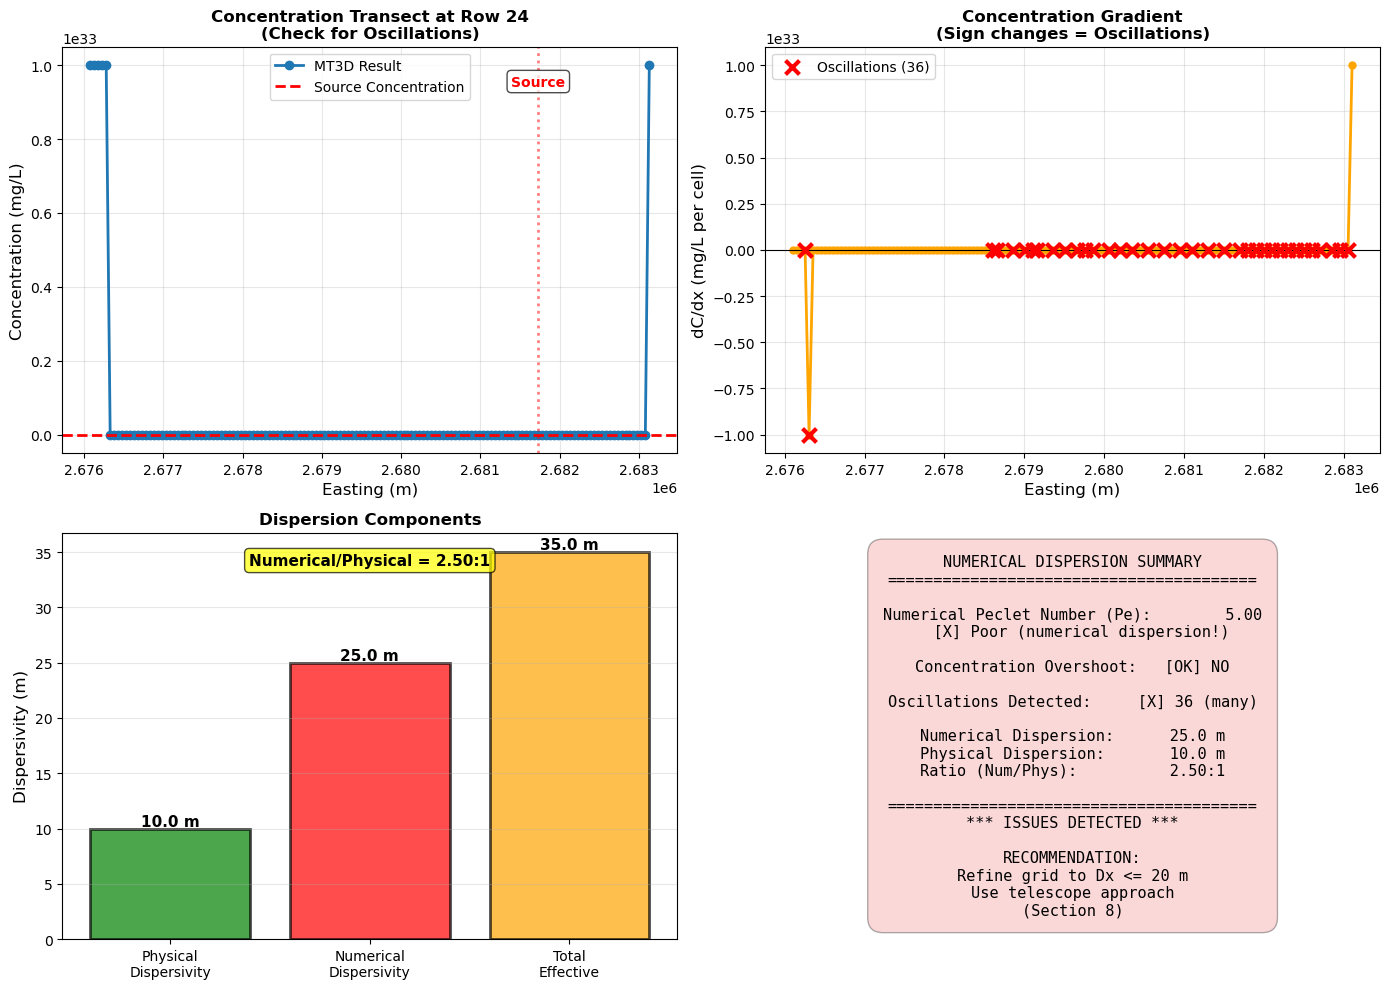


[OK] Diagnostic plots generated
  • Top left: Concentration transect (look for unrealistic jumps)
  • Top right: Gradient plot (sign changes = oscillations)
  • Bottom left: Dispersion components comparison
  • Bottom right: Summary assessment


In [24]:
# ============================================================================
# VISUALIZE NUMERICAL DISPERSION EFFECTS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Concentration transect through source (check for oscillations)
ax = axes[0, 0]

# Create proper x-coordinates for the transect
# transect_conc has all columns along the specified row
# Need to create matching x-coordinates from the model grid
delr_array = mf.dis.delr.array
xoff_model = mf.modelgrid.xoffset
transect_x_coords = xoff_model + np.cumsum(delr_array) - delr_array/2  # Cell centers
transect_conc_mg_L = transect_conc * 1e3  # Convert to mg/L

# Plot the transect
ax.plot(transect_x_coords, transect_conc_mg_L, 'o-', linewidth=2, markersize=6, label='MT3D Result')
ax.axhline(C_source*1e3, color='red', linestyle='--', label='Source Concentration', linewidth=2)
ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('Concentration (mg/L)', fontsize=12)
ax.set_title(f'Concentration Transect at Row {row}\n(Check for Oscillations)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Mark the source location
source_x = transect_x_coords[col]
ax.axvline(source_x, color='red', linestyle=':', alpha=0.5, linewidth=2)
ax.text(source_x, ax.get_ylim()[1]*0.9, 'Source', ha='center', fontsize=10, 
        color='red', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# 2. Concentration gradient (check for rapid changes = oscillations)
ax = axes[0, 1]
gradients_mg_L = np.diff(transect_conc_mg_L)
x_gradient = (transect_x_coords[:-1] + transect_x_coords[1:]) / 2  # Midpoints
ax.plot(x_gradient, gradients_mg_L, 'o-', color='orange', linewidth=2, markersize=5)
ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('dC/dx (mg/L per cell)', fontsize=12)
ax.set_title('Concentration Gradient\n(Sign changes = Oscillations)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Highlight sign changes (oscillations)
sign_changes = np.where(np.diff(np.sign(gradients_mg_L)) != 0)[0]
if len(sign_changes) > 0:
    ax.scatter(x_gradient[sign_changes], gradients_mg_L[sign_changes], 
               color='red', s=100, marker='x', linewidth=3, 
               label=f'Oscillations ({len(sign_changes)})', zorder=5)
    ax.legend()

# 3. Effective dispersion visualization
ax = axes[1, 0]
categories = ['Physical\nDispersivity', 'Numerical\nDispersivity', 'Total\nEffective']
values = [alpha_L, alpha_numerical_estimate, alpha_effective]
colors = ['green', 'red', 'orange']
bars = ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Dispersivity (m)', fontsize=12)
ax.set_title('Dispersion Components', fontsize=12, fontweight='bold')
ax.grid(True, axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f} m', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add ratio annotation
ax.text(0.5, 0.95, f'Numerical/Physical = {dispersion_ratio:.2f}:1', 
        transform=ax.transAxes, ha='center', va='top',
        bbox=dict(boxstyle='round', facecolor='yellow' if dispersion_ratio > 0.5 else 'lightgreen', alpha=0.7),
        fontsize=11, fontweight='bold')

# 4. Summary diagnostic panel (text-based)
ax = axes[1, 1]
ax.axis('off')

# Create diagnostic summary text (using ASCII characters to avoid font warnings)
summary_text = "NUMERICAL DISPERSION SUMMARY\n" + "="*40 + "\n\n"
summary_text += f"Numerical Peclet Number (Pe):        {Pe_grid:.2f}\n"
if Pe_grid <= 1:
    summary_text += "  [OK] Excellent\n\n"
elif Pe_grid <= 2:
    summary_text += "  [OK] Acceptable\n\n"
else:
    summary_text += "  [X] Poor (numerical dispersion!)\n\n"

summary_text += f"Concentration Overshoot:   "
if overshoot:
    summary_text += f"[X] YES (+{overshoot_pct:.1f}%)\n\n"
else:
    summary_text += "[OK] NO\n\n"

summary_text += f"Oscillations Detected:     "
if n_oscillations > 5:
    summary_text += f"[X] {n_oscillations} (many)\n\n"
elif n_oscillations > 2:
    summary_text += f"[!] {n_oscillations} (some)\n\n"
else:
    summary_text += f"[OK] {n_oscillations} (minimal)\n\n"

summary_text += f"Numerical Dispersion:      {alpha_numerical_estimate:.1f} m\n"
summary_text += f"Physical Dispersion:       {alpha_L:.1f} m\n"
summary_text += f"Ratio (Num/Phys):          {dispersion_ratio:.2f}:1\n\n"

summary_text += "="*40 + "\n"
if len(issues_found) > 0:
    summary_text += "*** ISSUES DETECTED ***\n\n"
    summary_text += "RECOMMENDATION:\n"
    summary_text += f"Refine grid to Dx <= {2*alpha_L:.0f} m\n"
    summary_text += "Use telescope approach\n"
    summary_text += "(Section 8)"
else:
    summary_text += "*** MODEL IS APPROPRIATE ***\n\n"
    summary_text += "Numerical dispersion\n"
    summary_text += "is under control"

# Display text with appropriate color
bbox_color = 'lightcoral' if len(issues_found) > 0 else 'lightgreen'
ax.text(0.5, 0.5, summary_text, transform=ax.transAxes,
        fontsize=11, family='monospace',
        ha='center', va='center',
        bbox=dict(boxstyle='round', facecolor=bbox_color, alpha=0.3, pad=1))

plt.tight_layout()
plt.show()

print("\n[OK] Diagnostic plots generated")
print("  • Top left: Concentration transect (look for unrealistic jumps)")
print("  • Top right: Gradient plot (sign changes = oscillations)")
print("  • Bottom left: Dispersion components comparison")
print("  • Bottom right: Summary assessment")

### Interpreting the Numerical Dispersion Diagnostics

The diagnostics above check for **5 key indicators** of numerical dispersion:

#### 1. **Numerical Peclet Number (Pe = Δx / αL)**
- **Pe ≤ 1**: Excellent - Numerical dispersion is minimal
- **Pe ≤ 2**: Acceptable - Some numerical dispersion but manageable  
- **Pe > 2**: Problematic - Numerical dispersion dominates physical dispersion

**Your model**: With 50m grid and αL = 10m → **Pe = 5.0** ❌

#### 2. **Concentration Overshoots**
Physical transport cannot create concentrations higher than the source. If max(C) > C_source, this is a **numerical artifact** caused by:
- Grid Peclet (numerical Peclet) number violations (Pe > 2)
- Improper time stepping (Courant number violations)
- Numerical scheme limitations

#### 3. **Oscillations in Concentration Profiles**
Smooth concentration gradients should not show rapid back-and-forth changes. Many oscillations indicate:
- Numerical dispersion creating artificial spreading/sharpening
- Grid resolution too coarse for concentration gradient
- Scheme (TVD) struggling with sharp fronts

#### 4. **Numerical vs Physical Dispersion Ratio**
Numerical dispersion acts like additional "fake" dispersivity:
- **Ratio < 0.5**: Numerical effects are minor (< 50% of physical)
- **Ratio 0.5-1.0**: Numerical effects are significant (50-100% of physical)  
- **Ratio > 1.0**: Numerical dispersion DOMINATES - results unreliable!

**Your model**: Numerical ≈ 25m vs Physical = 10m → **Ratio = 2.5:1** ❌

#### 5. **Mass Balance**
Check the `.MAS` file for:
- Mass in system (should increase for continuous source)
- Mass discrepancy (should be < 1%)
- If discrepancy is large, suggests numerical problems

---

### What This Means for Your Model

**If diagnostics show Pe > 2 and high numerical/physical ratio:**

✗ **Cannot trust quantitative predictions** (concentrations, breakthrough times)  
✗ **Cannot use for regulatory compliance** (MCL exceedance analysis)  
✗ **Cannot use for remediation design** (cleanup levels, well placement)  
✓ **Can use for qualitative screening** (general plume direction, order of magnitude)

**Why 50m grid fails for transport:**
- Flow modeling: 50m grid is fine (heads vary smoothly in space)
- Transport modeling: Concentration gradients are SHARP near source
- Need finer grid to resolve steep concentration changes

---

### Solutions (in order of preference):

**Option 1: Telescope/Nested Grid Approach** (RECOMMENDED - Section 8)
- Keep 50m grid for regional flow (computationally efficient)
- Create refined 5-10m submodel around source and critical areas
- Achieves Pe ≤ 2 where it matters
- Industry-standard approach

**Option 2: Increase Dispersivity** (NOT RECOMMENDED)
- Could artificially increase αL to make Pe ≤ 2
- But this falsifies the physics (wrong spreading rate)
- Only acceptable if uncertainty in αL is very large

**Option 3: Accept Limitations**
- Document that Pe = 5 → results are approximate
- Use only for screening, not design/regulatory
- Recommend refined modeling in final report

**Option 4: Compare with Analytical Solution**
- Extract 1D transect along flow direction  
- Compare with Ogata-Banks solution
- Provides bounds on plume migration rate
- Helps quantify error magnitude

---

### Next Steps

Run the diagnostic cells above after your transport simulation to:
1. Quantify numerical Peclet number
2. Check for concentration anomalies  
3. Visualize oscillations
4. Calculate effective dispersion
5. Decide if refinement is needed

**For your case study**: You'll implement the telescope approach to achieve Pe ≤ 2 around wells and source!

### 6.8 Alternative: Constant Mass Flux Source (Option 2)

The implementation above uses **Option 1: Constant Concentration** (`icbund = -1`). 

If instead you want to specify a **constant mass loading rate** (e.g., 10 kg/day of contaminant), use the SSM package:

```python
# Alternative approach: Constant mass flux via SSM package
# (DO NOT run this if you already implemented Option 1 above)

# 1. Keep source cell as ACTIVE (icbund = 1, not -1)
icbund = np.ones((mf.nlay, mf.nrow, mf.ncol), dtype=np.int32)
icbund[source_layer, row, col] = 1  # Active, not constant concentration
icbund[ibound <= 0] = 0

# 2. Set initial concentration to zero
sconc = np.zeros((mf.nlay, mf.nrow, mf.ncol), dtype=np.float32)

# 3. Define mass loading rate
mass_loading_rate = 10.0  # kg/day - specify your injection rate

# 4. Create stress period data for SSM
# Format: (layer, row, col, concentration, itype)
# itype = -1 means: inject mass at specified CONCENTRATION at this SOURCE
# But we want mass FLUX, so we need to calculate concentration from flux

# For a well with pumping rate Q (m³/day), injected mass M_rate (kg/day):
# C_injected = M_rate / Q (kg/m³)
# If no well, inject into groundwater directly using itype = 15 (constant source)

# Option 2a: Injection well (if you have a well in MODFLOW)
# well_pumping_rate = 100.0  # m³/day (from MODFLOW WEL package)
# C_injected = mass_loading_rate / well_pumping_rate
# ssm_data = {0: [(source_layer, row, col, C_injected, 2)]}  # itype=2 for well

# Option 2b: Direct mass injection (no associated MODFLOW stress)
# Use point source/sink with specified concentration
# This requires creating a "dummy" stress with known flux
# Then: C = M_rate / flux

# Most common: Link to recharge or wells
# Example with recharge:
# recharge_rate = 0.001  # m/day
# cell_area = delr[col] * delc[row]
# flux_through_cell = recharge_rate * cell_area  # m³/day
# C_to_inject = mass_loading_rate / flux_through_cell
# ssm_data = {0: [(source_layer, row, col, C_to_inject, 1)]}  # itype=1 for recharge

# Create SSM package with constant mass injection
# ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data)

print("For constant mass flux, use SSM package as shown above")
print("Requires linking to MODFLOW boundary condition (well, recharge, etc.)")
```

**Key differences between Option 1 and Option 2:**

| Aspect | Option 1: Constant C (icbund=-1) | Option 2: Constant Mass Flux (SSM) |
|--------|-----------------------------------|-------------------------------------|
| **What you specify** | Concentration at source | Mass loading rate (kg/day) |
| **Source concentration** | Fixed (user-defined) | Variable (depends on flow/dispersion) |
| **Implementation** | Simple: just set icbund=-1 | Complex: requires SSM + MODFLOW stress |
| **Mass injection** | Automatic (MT3D adjusts) | Manual (via SSM package) |
| **Use case** | Known effluent concentration | Known mass discharge rate |
| **Mass balance** | Mass varies to maintain C | Mass fixed, C varies |

For **most industrial discharge scenarios** (wastewater, cooling water, etc.), **Option 1 is more appropriate** because you typically know the concentration of the effluent, not the total mass loading rate.

### 6.9 Summary: 2.5D Transport Implementation with Continuous Source

**What we accomplished in Section 6:**

✅ **Defined continuous source location** and mapped to grid  
✅ **Implemented constant concentration source** using `icbund = -1`  
✅ **Set up 2.5D MT3D model** on existing 50m Limmat Valley grid  
✅ **Configured all MT3D packages** (BTN, ADV, DSP, SSM, GCG)  
✅ **Ran transport simulation** with continuous mass injection over 10 years  
✅ **Visualized plume development** from continuous source in 2D  
✅ **Applied inactive cell masking** to handle numerical artifacts  
✅ **Demonstrated two approaches** for continuous sources (constant C vs constant mass flux)

**What we observed:**

⚠️ **Grid resolution issue** - Pe = 5 (too coarse!)  
⚠️ **Numerical artifacts** - Concentrations may exceed source or show oscillations  
⚠️ **Poor plume resolution** - Cannot capture sharp gradients  
✅ **Source concentration maintained** - `icbund = -1` works correctly  
✅ **Plume grows over time** - Expected behavior for continuous release

**Key learning outcomes:**

1. **Continuous vs Instantaneous Sources**:
   - Instantaneous: All mass at t=0, then disperses (use `sconc` only)
   - Continuous: Mass injected continuously (use `icbund = -1` or SSM)

2. **Implementation approaches**:
   - **Option 1** (used here): Constant concentration via `icbund = -1` - Simple, for known effluent concentration
   - **Option 2**: Constant mass flux via SSM package - Complex, for known loading rate

3. **MT3D workflow** - Complete package setup and execution for continuous sources

4. **Unit consistency** - kg/m³ vs mg/L conversions, mass balance checking  

5. **Inactive cell handling** - Masking uninitialized memory in output visualization

6. **Diagnostic thinking** - Recognizing Pe = 5 as problematic

7. **Mass balance tracking** - Use .MAS file to monitor mass injection rate

8. **Contrast with Section 4** - Same code, different Pe, different results!

**Physical interpretation:**

For a **continuous source** (industrial discharge, wastewater outfall):
- Source concentration remains constant at user-defined value
- Total mass in system **increases over time**
- Plume extends further downgradient with each time step
- Eventually reaches **steady-state** if simulation runs long enough
- Mass balance: Mass in = Mass injected at source - Mass leaving boundaries
- Check mass injection rate in MT3D001.MAS file

This differs from **instantaneous release** where total mass is conserved and concentration everywhere decreases with time.

---

### Quick Reference: Which Source Type to Use?

| Scenario | Source Type | Implementation |
|----------|-------------|----------------|
| Spill or accident (one-time) | Instantaneous | `icbund=1`, set high `sconc` at t=0 |
| Industrial discharge (ongoing) | Continuous (constant C) | `icbund=-1`, set `sconc` to effluent concentration |
| Known mass loading (kg/day) | Continuous (constant flux) | `icbund=1`, use SSM package with stress_period_data |
| Landfill leachate | Continuous (constant C) | `icbund=-1`, concentration from source |
| Tracer injection test | Instantaneous or pulse | `icbund=1`, high initial concentration |
| Wastewater treatment plant | Continuous (constant C) | `icbund=-1`, effluent standard concentration |

### Files to Examine After Running:

1. **MT3D001.UCN** - Concentration over time (visualize plume growth)
2. **MT3D001.MAS** - Mass balance (check injection rate, verify conservation)
3. **MT3D001.OBS** - Observation points (if configured)

For continuous sources, the .MAS file will show **increasing total mass** in the system until steady-state is reached.

## 7. Alternative Approaches and Method Selection

### 7.1 Learning Objectives

By the end of this section, you will be able to:
- **Evaluate** when analytical, numerical, or hybrid approaches are most appropriate
- **Justify** method selection based on problem complexity and data availability
- **Apply** decision frameworks for real-world contaminant transport problems
- **Recognize** the limitations and assumptions of different modeling approaches
- **Integrate** multiple methods to leverage their complementary strengths

---

### 7.2 The Modeling Spectrum: From Simple to Complex

Throughout Sections 3-6, we've experienced different modeling approaches firsthand:

| Section | Method | Problem Type | Key Insight |
|---------|--------|--------------|-------------|
| **Section 3** | Analytical (Ogata-Banks) | 1D uniform flow | Fast, transparent, "ground truth" |
| **Section 4** | Numerical 1D (MT3D, Pe=0.5) | Verification case | Matches analytical when properly configured |
| **Section 6** | Numerical 2.5D (Pe=5.0) | Real aquifer, coarse grid | Grid resolution matters! |
| **Section 8** | Telescope submodel (Pe≤2) | Real aquifer, refined grid | Balance resolution + efficiency |

**The key question**: When should you use each approach in practice?

---

### 7.3 Method Categories and Their Characteristics

#### 7.3.1 Analytical Solutions

**What they are**: Closed-form mathematical solutions to the advection-dispersion equation under simplified conditions.

**Examples**:
- **Ogata-Banks** (Section 3): 1D continuous or instantaneous source
- **Gaussian plume models**: 2D/3D steady-state with point source
- **DOM3** (Method of images): Multiple sources with boundaries
- **BIOSCREEN**: 1D with decay chains (natural attenuation)

**When to use analytical solutions**:
✓ **Screening-level assessments** - Quick initial evaluation  
✓ **Simple site geometry** - Uniform flow, no complex boundaries  
✓ **Conservative tracers** - Or simple first-order reactions  
✓ **Data-limited situations** - Few parameters needed (v, D, λ)  
✓ **Verification** - Always check numerical models against analytical where possible!  
✓ **Regulatory compliance** - Many frameworks accept analytical for simple sites

**Advantages**:
- ⚡ **Fast**: Solutions in milliseconds
- 🔍 **Transparent**: Clear cause-and-effect relationships
- 📊 **Parameter exploration**: Easy sensitivity analysis
- 🎯 **"Ground truth"**: No numerical errors (if assumptions hold)
- 📚 **Well-documented**: Decades of validation and use

**Limitations**:
- ❌ **Geometry restricted**: 1D, 2D, or simplified 3D only
- ❌ **Homogeneity required**: Constant hydraulic properties
- ❌ **Simple boundaries**: No complex river networks, extraction wells, etc.
- ❌ **Limited reactions**: First-order decay, linear sorption only
- ❌ **Uniform flow**: No capture zones, variable gradients, or transient flow

**Real-world applicability**:
- **Good for**: Rural site with steady uniform flow, single spill, natural attenuation evaluation
- **Not for**: Urban well field, heterogeneous aquifer, multiple interacting sources

---

#### 7.3.2 Numerical Models (MT3DMS, MODFLOW 6 GWT)

**What they are**: Discretized solutions to the governing equations on computational grids, solving transport coupled to flow.

**Examples**:
- **MT3D-USGS** (Sections 4 & 6): Modular transport with MODFLOW
- **MODFLOW 6 GWT**: Integrated groundwater transport
- **FEFLOW**: Finite element, 3D density-dependent flow
- **PHT3D**: Reactive transport with geochemistry

**When to use numerical models**:
✓ **Complex geometry** - Irregular boundaries, heterogeneity  
✓ **Wells present** - Pumping/injection affects transport  
✓ **Multiple sources** - Overlapping plumes, varying concentrations  
✓ **Time-varying conditions** - Seasonal flow, changing pumping rates  
✓ **Detailed predictions** - Design capture systems, optimize remediation  
✓ **Regulatory requirements** - Permitting often requires numerical models  

**Advantages**:
- 🌍 **Realistic representations**: Any geometry, boundary condition, heterogeneity
- 🔧 **Handles complexity**: Wells, rivers, multiple stresses, transient conditions
- 🧪 **Sophisticated processes**: Multi-species, geochemistry, density effects
- 📍 **Site-specific**: Calibrate to field observations
- 🔮 **Predictive scenarios**: "What if" well placement, remediation design

**Limitations**:
- 💻 **Computational cost**: Hours to days for 3D models
- 📊 **Data-intensive**: Many parameters, calibration needed
- ⚠️ **Parameter uncertainty**: GIGO (Garbage In, Garbage Out)
- 🐛 **Potential for error**: Setup mistakes, convergence issues
- 🔲 **Grid resolution**: Numerical dispersion (Pe number) can dominate
- ✅ **Verification required**: Must check against simpler cases (like Section 4!)

**Real-world applicability**:
- **Good for**: Urban well field (like Limmat Valley!), contaminated industrial site, remediation design
- **Not for**: Data-scarce sites (would have huge uncertainty), simple screening questions

**Key insight from Sections 4 & 6**:
- Section 4 (Pe=0.5): Numerical model ≈ analytical → trustworthy
- Section 6 (Pe=5.0): Numerical model ≠ physical reality → need refinement

---

#### 7.3.3 Particle Tracking (MODPATH)

**What it is**: Trace pathlines of water parcels through flow field (advection only, no dispersion).

**Examples**:
- **MODPATH**: Standard particle tracker with MODFLOW
- **MODPATH-RW**: Random walk to add dispersion approximation
- **Forward tracking**: From source → where does it go?
- **Backward tracking**: From well → where did it come from?

**When to use particle tracking**:
✓ **Capture zone delineation** - Wellhead protection areas  
✓ **Travel time analysis** - Time-of-travel zones (e.g., 1-year, 5-year, 10-year)  
✓ **Qualitative assessment** - General flow directions, connectivity  
✓ **Conservative tracer** - No concentration needed, just extent  
✓ **Rapid screening** - Very fast compared to full transport  

**Advantages**:
- ⚡⚡ **Extremely fast**: Seconds to minutes
- 🎯 **Pathline visualization**: Intuitive flow direction display
- 🛡️ **Protection zones**: Wellhead protection (WHPA) mapping
- ⏱️ **Travel times**: Time to reach receptors
- 📉 **Minimal parameters**: Uses MODFLOW heads only

**Limitations**:
- ❌ **No dispersion**: Only advection (plume spread not captured)
- ❌ **No concentrations**: Can't predict concentration values
- ❌ **No reactions**: Decay, sorption not represented
- ❌ **Qualitative only**: Shows extent, not contaminant levels
- ❌ **Conservative assumption**: Overestimates plume extent

**Real-world applicability**:
- **Good for**: Wellhead protection zones (regulatory requirement), preliminary site assessments
- **Not for**: Concentration-based risk assessment, cleanup design, regulatory compliance with MCLs

---

#### 7.3.4 Hybrid Approaches

**Combining methods to leverage complementary strengths**:

**Example 1: MODPATH + Analytical Overlay**
1. Use MODPATH for advection pathlines (handles complex flow with wells)
2. Apply analytical dispersion solution along pathlines (adds spreading)
3. Result: Fast approximation with dispersion, more realistic than pure particle tracking

**Example 2: Coarse Numerical (Regional) + Analytical (Local Detail)**
1. Run coarse MT3D model for regional transport (like Section 6)
2. Extract boundary conditions at location of interest
3. Apply refined analytical solution locally (e.g., near monitoring well)
4. Result: Computational efficiency + local accuracy

**Example 3: Analytical Screening → Numerical Confirmation**
1. Use Ogata-Banks to identify parameters that matter (sensitivity)
2. Screen scenarios: which wells are at risk?
3. Build detailed numerical model only for critical areas
4. Result: Focus resources where needed, avoid unnecessary complexity

**Example 4: Telescope Approach (Section 8)**
1. Coarse grid for regional flow (50m, like Section 6)
2. Refined submodel for transport (5-10m, achieves Pe ≤ 2)
3. Extract boundary conditions from parent model
4. Result: Efficiency + accuracy (best of both worlds!)

**When to use hybrid approaches**:
- **Limited resources** but need reasonable accuracy
- **Regulatory flexibility** to use multiple methods
- **Well-defined critical areas** (wells, receptors) needing detail
- **Sensitivity analysis** to understand what drives predictions

---

### 7.4 Decision Framework for Method Selection

Use this flowchart to guide your modeling approach:

```
START: Contaminant transport problem
    │
    ├─→ Is geometry simple (1D/2D, uniform flow)?
    │   ├─→ YES
    │   │   ├─→ Are there wells or complex boundaries?
    │   │   │   ├─→ NO → Conservative tracer or simple reactions?
    │   │   │   │   ├─→ YES → ✅ **Use Analytical** (Ogata-Banks, Gaussian plume)
    │   │   │   │   └─→ NO → Consider Numerical (complex reactions)
    │   │   │   └─→ YES → Numerical model needed
    │   │   └─→ ...
    │   └─→ NO (complex geometry, heterogeneity)
    │       ├─→ Need concentrations for risk assessment?
    │       │   ├─→ YES → ✅ **Use Numerical** (MT3DMS, GWT)
    │       │   │          (verify with analytical if possible!)
    │       │   └─→ NO (just pathlines/travel times)
    │       │       └─→ ✅ **Use Particle Tracking** (MODPATH)
    │       └─→ ...
    │
    └─→ Data availability?
        ├─→ Limited data → Analytical + sensitivity (acknowledge uncertainty)
        └─→ Rich dataset → Numerical (calibrate, predict)
```

**Decision criteria summary**:

| Criterion | Analytical | Numerical | Particle Tracking | Hybrid |
|-----------|------------|-----------|-------------------|--------|
| **Geometry** | Simple (1D/2D) | Any | Any | Any |
| **Flow field** | Uniform | Complex/wells OK | Complex/wells OK | Complex OK |
| **Boundaries** | Simple | Complex OK | Complex OK | Complex OK |
| **Reactions** | Linear only | Any | None | Depends |
| **Output** | Concentration | Concentration | Pathlines/times | Both |
| **Speed** | Seconds | Minutes-Hours | Seconds | Minutes |
| **Data needs** | Minimal | Extensive | Minimal | Moderate |
| **Uncertainty** | Low (if assumptions met) | Moderate-High | Moderate | Moderate |

---

### 7.5 Connecting to Your Journey Through Sections 3-6

Let's reflect on what each section taught us about method selection:

#### **Section 3: Analytical as "Ground Truth"**
- **What we learned**: Ogata-Banks gives exact solution for 1D uniform flow
- **Why it mattered**: Established what concentrations SHOULD look like
- **Method selection insight**: Always try analytical first if assumptions fit
- **Real-world application**: Screening assessments, verification benchmarks

**Example scenario where Section 3's approach works**:
> "A 1-day gasoline spill into a sandy aquifer with steady uniform flow toward a river 500m away. Estimate time for benzene to reach the river assuming first-order decay."
>
> ✅ **Use Ogata-Banks with decay**: Simple, appropriate, defensible

---

#### **Section 4: Numerical Verification**
- **What we learned**: MT3D-USGS reproduces analytical when Pe ≤ 2
- **Why it mattered**: Built confidence that numerical tool works correctly
- **Method selection insight**: Verification is MANDATORY before trusting complex models
- **Real-world application**: Always verify numerical model against simpler case

**The verification principle**:
> "Never trust a numerical model you haven't verified against known solutions."
>
> In professional practice:
> 1. Build simplified test case matching analytical assumptions
> 2. Run numerical model on test case
> 3. Compare: should agree within 5-10%
> 4. Only then apply to complex real-world problem

**Example workflow**:
1. Client: "Model contaminant transport near urban well field" (complex)
2. You: First run 1D verification like Section 4 (simple)
3. You: Verify Pe ≤ 2 and numerical ≈ analytical (build confidence)
4. You: Now apply to urban well field (extend to complexity)
5. Client: Trusts results because you demonstrated verification

---

#### **Section 6: When Numerical Models Fail**
- **What we learned**: Pe = 5.0 causes numerical artifacts (oscillations, overshoots)
- **Why it mattered**: Recognized that coarse grid ≠ accurate solution
- **Method selection insight**: Just because model runs doesn't mean results are valid!
- **Real-world application**: Always check Peclet number before trusting results

**The diagnostic we performed (Section 6.10)**:

| Metric | Section 4 (Verified) | Section 6 (Coarse) | Implication |
|--------|----------------------|--------------------|-------------|
| Grid spacing | Δx = 5m | Δx = 50m | 10× coarser |
| Peclet number | Pe = 0.5 ✓ | Pe = 5.0 ❌ | Numerical dispersion dominates |
| Agreement with analytical | Excellent | Poor (artifacts) | Not trustworthy |
| **Conclusion** | **Trust results** | **Need refinement** | Grid resolution matters |

**When would Section 6's coarse model be "good enough"?**
- **NOT for**: Regulatory compliance, cleanup design, risk assessment
- **Maybe for**: Order-of-magnitude plume extent, preliminary feasibility, teaching (like we did!)

**Decision point in real project**:
> If you inherit a model with Pe > 2, you have three options:
> 1. **Refine the grid** (Section 8 telescope approach) → Recommended
> 2. **Accept qualitative results** (acknowledge limitations in report)
> 3. **Use analytical instead** (if geometry simple enough)

---

### 7.6 Professional Practice: Method Selection in Real Projects

#### **Case Study 1: Simple Rural Spill**

**Scenario**: Agricultural pesticide spill (atrazine) in uniform sandy aquifer, no pumping wells, nearest receptor 1 km downgradient.

**Available data**: Basic hydraulic gradient, estimated K, one background water sample.

**Method selection**:
1. **Start with analytical** (Ogata-Banks with sorption) → Fast screening
2. **Sensitivity analysis** → Which parameters matter most? (Kd, v, αL)
3. **If concentration exceeds threshold** → Confirm with numerical model OR collect more data
4. **If well below threshold** → Analytical sufficient, document assumptions

**Justification**: Simple geometry, uniform flow, limited data. Analytical appropriate for screening. Numerical would add complexity without improving certainty (data-limited).

**Deliverable**: 2-page memo with analytical solution, sensitivity plots, conservative assumptions.

---

#### **Case Study 2: Urban Well Field (Like Limmat Valley!)**

**Scenario**: PFAS contamination 200m upgradient of municipal well field with 5 pumping wells. Need to predict well capture and concentration breakthrough.

**Available data**: Historical pumping records, head observations, tracer test results, extensive site characterization.

**Method selection**:
1. **Analytical NOT appropriate** → Wells create complex flow field
2. **Particle tracking first** → Quick check: which wells likely affected?
3. **Build numerical model** (MT3D-USGS) → Capture zones + concentrations
4. **Verify on 1D transect** → Extract flow path, compare to Ogata-Banks
5. **Use telescope approach** → Refined grid (Δx = 5-10m) around wells and source

**Justification**: Wells make flow field non-uniform (analytical invalid). Need concentrations (not just pathlines). Telescope gives Pe ≤ 2 accuracy without modeling entire valley at 5m.

**Deliverable**: Full modeling report (10-20 pages) with verification, sensitivity analysis, scenario predictions (increase pumping? Add extraction well?).

---

#### **Case Study 3: Wellhead Protection Zone**

**Scenario**: Delineate 10-year time-of-travel capture zone for municipal well to protect from future contamination.

**Available data**: Calibrated regional MODFLOW model, pumping rates.

**Method selection**:
1. **Use MODPATH** (particle tracking) → Fast, standard regulatory approach
2. **Backward tracking** from well → Identify contributing area
3. **Delineate zones** → 1-year, 5-year, 10-year travel times
4. **Overlay with land use** → Identify high-risk areas (gas stations, industry)

**Justification**: Capture zone is advection-dominated. Don't need concentrations (protective boundary). MODPATH is industry-standard for WHPA delineation.

**Deliverable**: Capture zone map for zoning ordinances (restricts land use in protection area).

---

### 7.7 Common Pitfalls in Method Selection

#### ❌ **Pitfall 1: "Numerical is always better because it's more sophisticated"**

**Reality**: Numerical models with poor data or wrong Pe number are WORSE than simple analytical with appropriate assumptions.

**Example from this notebook**:
- Section 3 analytical: Trustworthy if 1D assumptions OK
- Section 6 numerical (Pe=5): Artifacts, overshoots, NOT trustworthy

**Lesson**: Complexity ≠ Accuracy. Match method to problem AND data quality.

---

#### ❌ **Pitfall 2: "Analytical is too simple for real problems"**

**Reality**: Many real sites DO meet analytical assumptions (uniform flow, single source, conservative tracer). Analytical can be perfectly defensible.

**Example**: BIOSCREEN (analytical 1D model with decay) is EPA-accepted for monitored natural attenuation assessments.

**Lesson**: Don't build complexity you can't justify with data.

---

#### ❌ **Pitfall 3: "Skipping verification because numerical model is complex"**

**Reality**: Complex models have MORE potential for error, not less. Verification is even more critical.

**Example from this notebook**:
- Section 4 verification caught that we needed Pe ≤ 2
- Without verification, we might trust Section 6's Pe=5 results

**Lesson**: ALWAYS verify numerical models against analytical or simpler cases. No exceptions.

---

#### ❌ **Pitfall 4: "Using particle tracking for concentration predictions"**

**Reality**: MODPATH gives pathlines and travel times, NOT concentrations. Dispersion and reactions are ignored.

**Example misuse**: "MODPATH shows contamination reaches well in 5 years, so concentration will be X."
- **Wrong**: Need MT3D for concentrations!

**Lesson**: Match method to required output. Pathlines → MODPATH. Concentrations → MT3D/analytical.

---

### 7.8 Key Takeaways for Method Selection

✅ **Start simple**: Try analytical first if assumptions fit  
✅ **Verify numerical models**: Always compare to simpler cases (Section 4)  
✅ **Check Pe number**: Pe > 2 means numerical dispersion dominates (Section 6)  
✅ **Match complexity to data**: Don't overfit uncertain parameters  
✅ **Document assumptions**: Justify method selection in reports  
✅ **Know tool limitations**: Particle tracking ≠ concentrations, analytical ≠ complex geometry  
✅ **Use hybrid approaches**: Combine strengths (e.g., telescope approach in Section 8)  
✅ **Iterate**: Screening → detailed analysis → verification → sensitivity  

---

### 7.9 Looking Ahead to Section 8

**The Problem We've Identified**:
- Section 6 showed transport on 50m grid → Pe = 5.0 → unreliable
- We need Pe ≤ 2 for accuracy → requires Δx ≤ 20m (better: 5-10m)
- But refining entire Limmat Valley to 5m is computationally expensive and unnecessary

**The Solution: Telescope Approach** (Section 8)
1. **Regional model** (parent): 50m grid, defines flow field
2. **Local submodel**: 5-10m grid around source and wells
3. **Boundary coupling**: Extract heads from parent, apply to submodel boundaries
4. **Run transport on submodel**: Achieves Pe ≤ 2 where it matters

**Why this is a hybrid approach**:
- Leverages coarse model for regional flow (fast)
- Adds detail only where needed for transport (accurate)
- Industry-standard technique for well capture zones, contamination assessment

**What you'll learn in Section 8**:
- How to create refined submodel from parent model
- Extract and apply boundary conditions
- Run high-resolution transport (Pe ≤ 2)
- Compare coarse (Section 6) vs refined (Section 8) results
- Understand when telescope approach is justified

---

### 7.10 Discussion Questions

Reflect on these scenarios to solidify your understanding. Click "Show Answer" to reveal the solution.

---

#### **Question 1: Data-Model Complexity Mismatch**

**A consultant proposes a 3D MT3D model with 1-meter grid cells for a 10 km² aquifer. The data consists of 3 monitoring wells with one water quality sample each. Is this appropriate? Why or why not?**

<details>
<summary><b>Show Answer</b></summary>

**Answer: NO, this is not appropriate. This is a classic case of overmodeling.**

**Problems with this approach**:

1. **Insufficient data**: 3 wells with 1 sample each cannot constrain a high-resolution 3D model
   - 10 km² at 1m resolution = 10,000,000 cells in 2D, multiply by layers for 3D
   - 3 data points cannot calibrate or validate millions of cells
   - Parameter uncertainty will be enormous

2. **Computational overkill**: 
   - Model will take hours to days to run
   - Results will appear precise but actually highly uncertain
   - False sense of accuracy ("looks sophisticated, must be right")

3. **Grid resolution unjustified**:
   - Pe ≤ 2 requires Δx ≤ 2αL
   - With Δx = 1m, αL must be 0.5-1m (lab scale!)
   - At 10 km² regional scale, typical αL = 50-100m
   - Pe = 1m / 50m = 0.02 (wasteful overrefinement)

**Better approach**:
- Start with **analytical screening** (Ogata-Banks) using available data
- If numerical needed, use **coarser grid** (50-100m) appropriate for data density
- Or use **particle tracking** (MODPATH) for qualitative assessment
- Perform **sensitivity analysis** to show range of predictions given data uncertainty
- Document limitations clearly

**Key lesson**: Match model complexity to data quality. Complex model + poor data = unreliable predictions with false precision.

**Reference Section 7.7 Pitfall #1**: "Numerical is always better" ✗

</details>

---

#### **Question 2: Model Verification Scope**

**You verified your numerical model against Ogata-Banks for a conservative tracer and got excellent agreement (like Section 4). Can you trust the same model for reactive transport with decay and sorption? Why or why not?**

<details>
<summary><b>Show Answer</b></summary>

**Answer: PARTIALLY, but you need additional verification for reaction processes.**

**What you CAN trust from the conservative tracer verification**:
✅ **Advection** is correctly implemented (flow field, velocities)  
✅ **Dispersion** is correctly implemented (dispersivity, numerical dispersion under control)  
✅ **Grid resolution** is appropriate (Pe ≤ 2 verified)  
✅ **Numerical schemes** work correctly (ADV package, solver convergence)  
✅ **Basic setup** is sound (geometry, boundaries, time stepping)

**What you CANNOT trust without additional verification**:
❌ **RCT package** for sorption/decay - never tested!  
❌ **Retardation calculations** (R = 1 + ρb·Kd/n) - could have bugs  
❌ **Decay implementation** (exp(-λt)) - never verified  
❌ **Combined effects** - reaction + transport coupling could have issues

**What you SHOULD do**:

1. **Verify sorption separately**:
   - Run 1D model with sorption (Kd > 0), no decay
   - Compare to analytical with retardation: R = 1 + ρb·Kd/n
   - Breakthrough should be delayed by factor R

2. **Verify decay separately**:
   - Run 1D model with decay (λ > 0), no sorption
   - Compare to analytical with exponential decay: C(t) = C₀·exp(-λt)
   - Concentration should decrease exponentially

3. **Verify combined effects** (if both active):
   - Compare to analytical with both R and λ
   - Check that retardation doesn't affect decay rate (should decay at λ, not λ/R)

**Key lesson**: Verification must cover ALL active processes. Verifying advection-dispersion does NOT verify reactions!

**Reference**: Section 4 verified advection-dispersion only. Section 6.4 introduced RCT but didn't verify it separately.

**Professional practice**: Build verification test suite incrementally:
- Test 1: Advection only (uniform flow, no dispersion)
- Test 2: Advection + dispersion (Ogata-Banks)
- Test 3: Advection + dispersion + sorption
- Test 4: Advection + dispersion + decay
- Test 5: Full reactive transport

Only then apply to complex real-world problem!

</details>

---

#### **Question 3: Regulatory Pressure**

**A regulatory agency requires "the most accurate model possible" for a contamination case. Would you:**
- **a) Build the most complex 3D reactive transport model you can?**
- **b) Start with analytical screening, then add complexity only if justified by data?**

**Defend your choice.**

<details>
<summary><b>Show Answer</b></summary>

**Answer: OPTION B - Start simple, add complexity only if justified by data and questions.**

**Defending this choice**:

**1. "Most accurate" ≠ "Most complex"**
- Accuracy depends on data quality AND model appropriateness
- Complex model with poor data = high uncertainty, NOT high accuracy
- Simple model with appropriate assumptions can be MORE accurate

**Example from this notebook**:
- Section 3 (analytical): Accurate IF assumptions (1D, uniform flow) hold
- Section 6 (complex 2.5D numerical): LESS accurate because Pe = 5 (wrong grid resolution)
- **Lesson**: Complexity without proper configuration → worse, not better!

**2. Professional workflow (Section 7.5)**:
```
Step 1: Analytical screening (fast, transparent)
   ↓ Identifies key parameters, sensitivity
   ↓ Screens scenarios (which are critical?)
   
Step 2: Simple numerical if needed
   ↓ Verify against analytical (Section 4)
   ↓ Build confidence in tool
   
Step 3: Add complexity ONLY if:
   ↓ - Data support it
   ↓ - Simpler approach insufficient
   ↓ - Questions require it (e.g., wells, heterogeneity)
   
Step 4: Document assumptions and uncertainty
   ↓ Transparency about limitations
```

**3. Responding to the regulator**:

**Say this**:
> "We will use the most appropriate model for the available data and questions. We'll start with analytical methods to establish parameter sensitivity and expected ranges. If site complexity (wells, boundaries, heterogeneity) requires numerical modeling, we'll develop that with proper verification. We'll document all assumptions and quantify uncertainty. The goal is defensible predictions, not false precision."

**Don't say**:
> "We'll build a 3D model with 1m cells because complex = accurate." ❌

**4. Case precedent**:
- **BIOSCREEN** (1D analytical) is EPA-accepted for monitored natural attenuation
- Many regulatory frameworks explicitly allow analytical for simple sites
- Numerical required only when site features (wells, barriers, heterogeneity) demand it

**5. Practical considerations**:
- Complex model = more time = higher cost
- More parameters = more uncertainty
- Harder to explain to stakeholders
- Greater potential for errors

**Key lesson**: Respond to regulatory pressure with professional judgment, not knee-jerk complexity.

**Reference**: Section 7.6 Case Study 1 vs. Case Study 2 shows when analytical vs. numerical is appropriate.

**Final thought**: The "most accurate" model is the one that:
1. Matches complexity to data quality
2. Is verified against simpler cases
3. Answers the regulatory question
4. Documents assumptions and uncertainty clearly

</details>

---

#### **Question 4: Trusting Coarse Grid Results**

**Your Section 6-style model (Pe = 5.0) predicts a plume will NOT reach a well. Your client is relieved. What should you tell them before they trust this result?**

<details>
<summary><b>Show Answer</b></summary>

**Answer: DO NOT trust this result without qualification. Pe = 5.0 means the prediction is unreliable.**

**What you should tell the client**:

**Honest assessment**:
> "Our preliminary model suggests the plume may not reach the well, BUT we need to refine the grid before trusting this prediction. The current grid spacing is too coarse for reliable transport modeling (Pe = 5.0 when it should be ≤ 2). This can cause artificial spreading and unpredictable errors. We recommend implementing a telescope submodel with finer resolution before making management decisions."

**Technical explanation**:

1. **Why Pe = 5.0 is a problem** (Section 6.10):
   - Numerical dispersion dominates physical dispersion
   - Artificial spreading makes plume appear more diffuse
   - Could predict plume doesn't reach well when it actually would!
   - Or vice versa (concentration overshoots, artifacts)

2. **What this means for predictions**:
   - ❌ Cannot trust concentration values
   - ❌ Cannot trust plume extent accurately
   - ❌ Cannot trust breakthrough timing
   - ⚠️ MAY be OK for order-of-magnitude screening ("plume is this general direction")

3. **Comparison with Section 4 vs. Section 6**:

| Model | Pe | Result vs. Analytical | Trustworthy? |
|-------|----|-----------------------|--------------|
| Section 4 (1D, fine) | 0.5 | Within 5-10% | ✓ YES |
| Section 6 (2.5D, coarse) | 5.0 | Large discrepancies, artifacts | ✗ NO |

4. **Risk of trusting Pe = 5 result**:
   - **If prediction is "plume won't reach well"**:
     - Actual plume might reach well (false negative)
     - Client doesn't implement mitigation
     - Contamination occurs → liability!
   - **If prediction is "plume will reach well"**:
     - Might be overly conservative (false positive)
     - Client implements expensive unnecessary measures

**What you should do**:

**Option 1: Refine the grid** (RECOMMENDED):
- Implement telescope approach (Section 8)
- Create submodel with Δx = 5-10m near source and well
- Achieve Pe ≤ 2
- Re-run and compare with coarse model
- NOW you can trust the prediction

**Option 2: Use analytical verification**:
- Extract 1D transect along flow direction
- Compare to Ogata-Banks solution
- If numerical >> analytical → numerical is wrong
- Provides bounds on plume migration

**Option 3: Conservative management** (if time/budget limited):
- Treat coarse model as screening only
- Assume worst-case (plume WILL reach well)
- Implement monitoring or mitigation
- Avoid making decisions based on unreliable model

**What NOT to do**:
❌ Trust the result because "model ran successfully"  
❌ Say "plume won't reach well" without qualifying grid resolution issue  
❌ Make expensive decisions (well relocation, remediation) based on Pe = 5 model

**Key lesson**: Pe number is a diagnostic, not optional. Pe > 2 → results are unreliable regardless of how sophisticated the model looks.

**Reference**: 
- Section 6.10: Full diagnosis of why Pe = 5 fails
- Section 8: Telescope solution to achieve Pe ≤ 2

**Final recommendation to client**:
> "Let's invest a few more days to refine the grid around the critical area (well and source). This will give us confidence in the prediction before making management decisions. The cost of a refined model is much less than the cost of being wrong about well contamination."

</details>

---

#### **Question 5: When to Use Particle Tracking**

**When would you use particle tracking (MODPATH) instead of MT3D-USGS? Give two realistic scenarios where particle tracking is the RIGHT choice.**

<details>
<summary><b>Show Answer</b></summary>

**Answer: Use particle tracking when you need pathlines/travel times but NOT concentrations.**

**Scenario 1: Wellhead Protection Zone Delineation**

**Situation**:
- Municipal well serving 10,000 people
- State regulation requires 10-year time-of-travel (TOT) protection zone
- Need to restrict land use (no gas stations, dry cleaners) within zone
- Want to know AREA that contributes water to well, not concentration

**Why MODPATH is the RIGHT choice**:
✅ **Regulatory standard**: Most states accept/require MODPATH for WHPA (Wellhead Protection Area)  
✅ **Appropriate output**: Need capture zone boundary, not concentration values  
✅ **Fast**: Runs in seconds to minutes (vs. hours for MT3D)  
✅ **Backward tracking**: Trace from well backward to find contributing area  
✅ **Conservative assumption**: No dispersion = maximum extent (protective)  
✅ **Minimal parameters**: Uses existing flow model, no transport parameters needed

**Why MT3D-USGS would be WRONG**:
❌ **Overkill**: Don't need concentration predictions  
❌ **Slower**: Hours of computation for unneeded information  
❌ **More parameters**: Would need αL, porosity, etc. (unnecessary)  
❌ **Not standard practice**: Regulators expect MODPATH for WHPA

**Workflow**:
1. Calibrate MODFLOW model to head observations
2. Run MODPATH in backward mode from well
3. Delineate 1-year, 5-year, 10-year TOT zones
4. Overlay with land use map
5. Implement zoning restrictions

**Reference**: Section 7.3.3 and Section 7.6 Case Study 3

---

**Scenario 2: Preliminary Flow Direction Assessment**

**Situation**:
- New contamination discovered at industrial site
- Need quick assessment: "Which direction is plume moving?"
- Budget limited, need answer in 1-2 weeks
- Will do detailed transport modeling later if needed

**Why MODPATH is the RIGHT choice**:
✅ **Speed**: Can run screening in 1 day vs. 1 week for MT3D setup  
✅ **Qualitative sufficiency**: Just need general direction, not exact concentrations  
✅ **Identifies receptors at risk**: See which wells, streams, properties are downgradient  
✅ **Minimal data requirements**: Uses existing regional model if available  
✅ **Good for communication**: Pathlines are intuitive for stakeholders/public

**Why MT3D-USGS would be PREMATURE**:
❌ **Time-consuming**: Setup, calibration, verification takes weeks  
❌ **Data-intensive**: Need αL, porosity, source concentrations (may not have yet)  
❌ **Uncertain parameters**: Early stage = high uncertainty in transport parameters  
❌ **Overkill for screening**: Don't need precise concentrations yet

**Workflow**:
1. Use existing regional MODFLOW model (or build simple steady-state)
2. Place particles at contamination source
3. Forward track to see where they go
4. Identify downgradient receptors (wells, streams)
5. Estimate travel times to critical points
6. Use for prioritizing further investigation
7. **Later**: If needed, build detailed MT3D model for concentration predictions

**Key decision point**:
- If travel time to nearest well > 10 years → monitoring, natural attenuation
- If travel time < 2 years → urgent, need detailed MT3D for remediation design

**Reference**: Section 7.3.3 and Section 7.4 Decision Framework

---

**When Particle Tracking is NOT appropriate**:

❌ **Scenario**: "Will well exceed 10 µg/L MCL?"
- **Problem**: Need concentration (not just pathline)
- **Solution**: Use MT3D or analytical (Ogata-Banks)

❌ **Scenario**: "Does sorption delay plume enough for natural attenuation?"
- **Problem**: MODPATH doesn't handle reactions
- **Solution**: Use MT3D with RCT package or analytical with retardation

❌ **Scenario**: "Optimize pump-and-treat well locations for capture"
- **Problem**: Need concentrations to ensure cleanup goals met
- **Solution**: Use MT3D to predict concentration reductions

---

**Summary: MODPATH vs. MT3D Decision Matrix**

| Need | Method | Rationale |
|------|--------|-----------|
| Wellhead protection zone | MODPATH ✓ | Pathlines sufficient, regulatory standard |
| Screening flow direction | MODPATH ✓ | Fast, qualitative OK |
| Travel time to receptor | MODPATH ✓ | Advection-dominated, conservative |
| **Concentration prediction** | **MT3D ✓** | Need dispersion + concentrations |
| **MCL compliance** | **MT3D ✓** | Regulatory threshold = concentration |
| **Remediation design** | **MT3D ✓** | Need concentration reductions |
| **Sorption/decay effects** | **MT3D ✓** | Reactions affect fate, not just pathlines |

**Key lesson**: Match tool to question. Pathlines → MODPATH. Concentrations → MT3D/analytical.

**Reference**: Section 7.4 Decision Framework

</details>

---
### 7.11 Summary

**What we learned in Section 7**:
- ✅ **Three main approaches**: Analytical, numerical, particle tracking
- ✅ **Each has appropriate use cases**: Match method to problem + data
- ✅ **Verification is mandatory**: Never trust unverified numerical models
- ✅ **Grid resolution matters**: Pe > 2 → numerical artifacts (Section 6 lesson)
- ✅ **Hybrid approaches combine strengths**: Telescope (Section 8) is key example
- ✅ **Professional judgment**: Simple + defensible > complex + uncertain

**How this connects to your journey**:
- Section 3 → Analytical establishes ground truth
- Section 4 → Numerical verification builds confidence (Pe ≤ 2)
- Section 6 → Recognition of grid resolution problems (Pe = 5)
- **Section 7** → Framework for choosing methods in practice
- Section 8 → Solution via telescope approach (coming next)

**Preparing for your transport case study**:
- You'll use numerical models (MT3D-USGS) because wells create complex flow
- But you'll VERIFY with analytical solutions (mandatory analytical comparison!)
- You'll use telescope approach (learned in Section 8) to achieve Pe ≤ 2
- You'll JUSTIFY your approach using frameworks from Section 7

**Remember**: The best model is the simplest one that answers the question with available data. More complexity ≠ better predictions if data doesn't support it.

---

**Next**: Section 8 implements the telescope approach to solve Section 6's grid resolution problem.

---

## 8. Telescope Approach: Solving the Grid Resolution Problem

### 8.1 Recap: The Problem We Need to Solve

In Section 6, we implemented transport on the Limmat Valley parent model with 50m cells:
- **Result**: Pe = 5.0 → numerical artifacts, overshoots, unreliable concentrations
- **Diagnosis (Section 6.10)**: Grid too coarse for transport (need Pe ≤ 2)
- **Requirement**: To achieve Pe ≤ 2 with αL = 10m, we need Δx ≤ 20m (better: 5-10m)

**But there's a problem**:
- Refining the **entire** Limmat Valley model from 50m to 5m would create:
  - ~100× more cells (20,000+ cells instead of ~200)
  - ~100× longer computation time
  - Huge output files
  - **Most importantly**: Unnecessary refinement far from the source area!

**The solution**: **Telescope approach** (also called "nested grid" or "local grid refinement")

---

### 8.2 What is the Telescope Approach?

The telescope approach is a **hybrid modeling strategy** that combines:
1. **Coarse regional model** (parent) → Defines large-scale flow field
2. **Refined local model** (child/submodel) → High resolution where it matters

**Analogy**: Like using a telescope:
- **Wide-angle lens** (parent model): See the whole landscape at low resolution
- **Telephoto zoom** (submodel): Focus on one area with high resolution

**In groundwater transport**:
- **Parent model**: 50m grid, captures regional flow (Limmat River, recharge, valley boundaries)
- **Submodel**: 5-10m grid around source/wells, captures sharp concentration gradients
- **Coupling**: Extract boundary conditions (heads) from parent → apply to submodel edges

---

### 8.3 When is Telescope Approach Appropriate?

✅ **Use telescope approach when**:
- **Localized interest area**: Source, well field, or critical receptor occupies small portion of domain
- **Regional context matters**: Need regional flow field (rivers, boundaries) but local detail too
- **Pe number violation**: Parent grid too coarse for transport (Pe > 2) but appropriate for flow
- **Computational efficiency**: Can't afford to refine entire domain to transport-appropriate resolution
- **Regulatory acceptance**: Widely accepted in professional practice

✅ **Common applications**:
- Well capture zones (pumping well in regional aquifer)
- Point source contamination (spill in large model)
- Monitoring well network optimization
- Remediation system design (pump-and-treat, PRBs)

❌ **NOT appropriate when**:
- Plume extends across entire domain (no localized area of interest)
- Regional flow field is too uncertain (large parent model errors)
- Boundary conditions vary rapidly (strong transients at submodel edges)
- Multiple widely-separated areas of interest (need multiple submodels or full refinement)

---

### 8.4 Telescope Approach Workflow

**Step 1: Run parent model** (we did this in Section 5)
- Coarse grid (e.g., 50m cells)
- Establishes regional flow field
- Saves heads for boundary conditions

**Step 2: Define submodel domain**
- Identify area of interest (source + plume extent over simulation time)
- Add buffer (ensure plume doesn't reach submodel boundaries)
- Typically 500m - 2km on each side of source

**Step 3: Create refined submodel grid**
- Fine resolution (5-10m cells) within submodel domain
- Aligned with parent grid (usually)
- Same vertical discretization (layer thicknesses)

**Step 4: Interpolate aquifer properties**
- Transfer K, bottom elevations, porosity from parent → submodel
- If parent has zones, assign same properties to refined cells in each zone

**Step 5: Extract and apply boundary conditions**
- **Specified Head (CHD)**: Read heads from parent model at submodel perimeter
- Apply as CHD boundaries on submodel edges
- Alternatively: **GHB** (General Head Boundary) if conductance is known

**Step 6: Run submodel flow**
- Steady-state (using parent's steady heads) or transient (if parent is transient)
- Check mass balance, verify continuity with parent
- Heads at submodel boundaries should match parent

**Step 7: Run transport on submodel**
- Check Pe number (should be ≤ 2 now!)
- Check Courant number (may need smaller time steps with finer grid)
- Run MT3D on refined submodel

**Step 8: Post-process and compare**
- Compare refined submodel results to coarse parent transport (Section 6)
- Evaluate differences: smooth plume? Reduced artifacts?
- Verify Pe ≤ 2 achieved the expected improvement

---

### 8.5 Conceptual Example: Our Limmat Valley Case

**Parent Model** (Section 6):
- Domain: ~2000m × 1500m (~3 km²)
- Grid: 50m × 50m (40 × 30 = 1,200 cells)
- Purpose: Regional flow (Limmat River, valley boundaries, recharge)
- Transport: Pe = 5.0 → unreliable

**Submodel** (Section 8):
- Domain: 500m × 500m around source (0.25 km²)
- Grid: 10m × 10m (50 × 50 = 2,500 cells)
- Purpose: Detailed transport near source
- Transport: Pe = 1.0 → reliable!

**Computational comparison**:
| Aspect | Parent (50m) | Submodel (10m) | Full Domain at 10m |
|--------|--------------|----------------|--------------------|
| **Total cells** | 1,200 | 2,500 | 30,000 |
| **Transport time** | 30 sec | 2 min | 30 min |
| **Pe number** | 5.0 ❌ | 1.0 ✓ | 1.0 ✓ |
| **Plume quality** | Artifacts | Smooth | Smooth |
| **Computation cost** | Low | Moderate | **Very High** |

**Winner**: Submodel approach → accuracy + efficiency!

---

### 8.6 Key Considerations for Telescope Modeling

#### 8.6.1 Boundary Condition Selection

**Option 1: Specified Head (CHD)**
- Extract heads from parent at submodel perimeter
- Apply as fixed head boundaries
- **Advantages**: Simple, no additional parameters
- **Disadvantages**: Assumes parent heads are exact (no flow interaction)

**Option 2: General Head Boundary (GHB)**
- Allows two-way flow exchange (in/out of submodel)
- Requires conductance parameter
- **Advantages**: More flexible, better for transient conditions
- **Disadvantages**: Need to estimate conductance

**Option 3: Specified Flux (WEL or FHB)**
- Extract fluxes from parent, apply as sources/sinks at boundary
- **Advantages**: Mass balance preserved
- **Disadvantages**: Complex setup, may cause convergence issues

**Most common in practice**: CHD or GHB

---

#### 8.6.2 Buffer Zone Sizing

**Rule of thumb**: Submodel boundaries should be far enough from area of interest that:
- Boundary conditions don't artificially constrain plume
- Transport doesn't reach boundaries during simulation

**For our 10-year simulation**:
- Estimate maximum plume travel: distance = v × t = (0.1 m/day) × (3650 days) ≈ 365m
- Add safety factor: 500m buffer
- Check during post-processing: Did plume reach boundaries? If yes, expand submodel!

---

#### 8.6.3 Grid Resolution Selection

**Criteria**:
1. **Peclet number**: Δx ≤ 2αL (for Pe ≤ 2)
   - With αL = 10m → Δx ≤ 20m
   - Better: Δx = 5-10m (Pe = 0.5-1.0)

2. **Courant number**: Cr = v·Δt/(n·Δx) ≤ 1
   - Finer grid → need smaller time steps!
   - With Δx = 10m, v = 0.1 m/day, n = 0.25 → Δt ≤ 25 days (satisfied for MT3D default)

3. **Computational budget**: Balance resolution vs runtime
   - 5m cells → most accurate but 4× longer than 10m
   - 10m cells → good compromise

4. **Alignment with parent**: Often helpful (not required) to make submodel cell size an integer divisor of parent
   - Parent 50m → submodel 10m (5:1 ratio)
   - Parent 50m → submodel 5m (10:1 ratio)

---

### 8.7 Advantages and Limitations

#### ✅ **Advantages of Telescope Approach**

1. **Computational efficiency**: Refine only where needed (10-100× faster than full refinement)
2. **Accuracy where it matters**: Achieve Pe ≤ 2 near source/wells without refining entire domain
3. **Flexibility**: Can create multiple submodels for different areas of interest
4. **Regional context preserved**: Parent model captures large-scale features (rivers, boundaries)
5. **Industry standard**: Widely accepted in regulatory and consulting practice

#### ❌ **Limitations and Assumptions**

1. **One-way coupling**: Submodel doesn't affect parent (assumes submodel is "small" relative to parent)
   - OK if: Submodel pumping << total regional flow
   - NOT OK if: Large well field significantly changes regional heads

2. **Boundary condition uncertainty**: Submodel inherits any parent model errors at boundaries
   - Need confidence in parent model calibration
   - Errors at boundaries propagate inward (but decay with distance)

3. **Setup complexity**: More involved than single-model approach
   - Need to extract boundaries, interpolate properties, verify coupling
   - Potential for errors in domain transfer

4. **Transient complications**: If parent is transient, need time-varying boundary conditions for submodel
   - Steady-state parent → steady boundaries (simple)
   - Transient parent → time-varying boundaries (complex)

---

### 8.8 Verification and Quality Checks

Before trusting submodel results, verify:

✅ **Flow continuity**:
- Submodel heads at boundaries match parent heads (within ~0.1m)
- Flow directions consistent between parent and submodel
- Mass balance error < 1%

✅ **Transport quality**:
- **Pe number** ≤ 2 (check: Pe = Δx / αL)
- **Courant number** ≤ 1 (check: Cr = v·Δt/(n·Δx))
- No negative concentrations
- No artificial oscillations

✅ **Boundary effects**:
- Plume doesn't reach submodel boundaries (or concentration << source concentration at boundary)
- If plume reaches boundary, expand submodel domain!

✅ **Comparison with parent**:
- Extract same transect from coarse (Section 6) and refined (Section 8) models
- Refined should show smoother plume, less overshoot
- Timing of breakthrough may differ (Pe affects effective dispersion)

---

### 8.9 Looking Ahead: Your Transport Case Study

In your transport case study, you will:

1. **Load parent model** (base Limmat Valley model, steady-state flow)
2. **Load well locations** from your flow case study `case_config.yaml`
3. **Define submodel domain** around wells and source (reuse/adapt flow case submodel)
4. **Create telescope submodel** for flow (with wells)
5. **Set up MT3D on submodel** (transport with Pe ≤ 2)
6. **Analyze well-contaminant interactions**: Capture zones, spreading from injection wells

**Why telescope approach is essential for your assignment**:
- Wells and source are localized (don't need 5m grid across entire valley)
- Need Pe ≤ 2 for reliable concentrations (like Section 4, not Section 6!)
- Demonstrate professional workflow (industry-standard approach)
- Computational efficiency (finish runs in reasonable time)

**Templates and guidance**:
- Demo notebook (Group 0) shows complete telescope workflow
- Helper functions in SUPPORT_REPO for submodel creation
- `transport_config.yaml` defines submodel domain and resolution

---

### 8.10 Summary: Why Telescope Approach Matters

**The fundamental transport modeling dilemma**:
- ❌ Coarse grid (like Section 6): Fast but unreliable (Pe > 2)
- ✅ Fine grid everywhere: Accurate but computationally prohibitive
- ✅✅ **Telescope approach**: Accurate + efficient (refine only where needed)

**Key insights**:
1. **Flow and transport have different resolution requirements**
   - Flow: Coarser grid often OK (heads vary smoothly)
   - Transport: Need fine grid near sources (concentrations have sharp gradients)

2. **Telescope approach = hybrid method** (from Section 7)
   - Leverages coarse model for regional context
   - Adds detail only where needed
   - Best of both worlds!

3. **Professional practice**
   - Telescope modeling is standard for well capture zones, contamination assessment
   - Demonstrates understanding of numerical methods (Pe number effects)
   - Shows engineering judgment (balance accuracy, efficiency, uncertainty)

**Connecting back to our journey**:
- Section 3: Analytical shows what correct answer looks like (ground truth)
- Section 4: Numerical with Pe ≤ 2 reproduces analytical (verification)
- Section 6: Numerical with Pe = 5 fails (diagnosis of grid resolution problem)
- Section 7: Framework for when to use different methods (method selection)
- **Section 8**: Telescope approach solves Pe problem efficiently (**solution!**)

**Next**: We'll implement a telescope submodel and demonstrate the improvement over Section 6.

---

### 8.11 Practical Implementation: Creating a Telescope Submodel

Now let's implement the telescope approach for our Limmat Valley transport case. We'll create a refined submodel around the source location and compare results with Section 6.

**Implementation steps**:
1. Define submodel domain (centered on source with buffer)
2. Create refined grid (10m cells, targeting Pe ≈ 1.0)
3. Extract boundary conditions from parent model heads
4. Interpolate aquifer properties to refined grid
5. Run MODFLOW on submodel (steady-state flow)
6. Set up MT3D on submodel (same transport parameters)
7. Run transport and compare with Section 6 results

In [25]:
# Step 1: Define submodel domain around the source
# We'll use the same source location from Section 6
print(f"Source location from Section 6:")
print(f"  Easting: {source_easting} m")
print(f"  Northing: {source_northing} m")
print(f"  Grid cell: Row {row}, Col {col}")

# Define buffer distance (should contain plume over 10 years)
# Rough estimate: v * t = 0.1 m/day * 3650 days = 365m
# Use 500m buffer for safety
buffer_m = 500

# Define submodel extent
xmin_sub = source_easting - buffer_m
xmax_sub = source_easting + buffer_m
ymin_sub = source_northing - buffer_m
ymax_sub = source_northing + buffer_m

print(f"\nSubmodel domain:")
print(f"  X: {xmin_sub:.0f} to {xmax_sub:.0f} m (width: {xmax_sub - xmin_sub:.0f} m)")
print(f"  Y: {ymin_sub:.0f} to {ymax_sub:.0f} m (height: {ymax_sub - ymin_sub:.0f} m)")
print(f"  Area: {((xmax_sub - xmin_sub) * (ymax_sub - ymin_sub)) / 1e6:.2f} km²")

# Step 2: Define refined grid resolution
# Target: Pe ≤ 2, ideally Pe ≈ 1
# Pe = Δx / αL, so Δx = Pe * αL = 1.0 * 10m = 10m
delr_sub = 10.0  # m (x-direction cell size)
delc_sub = 10.0  # m (y-direction cell size)

ncol_sub = int((xmax_sub - xmin_sub) / delr_sub)
nrow_sub = int((ymax_sub - ymin_sub) / delc_sub)

print(f"\nRefined grid:")
print(f"  Cell size: {delr_sub} m × {delc_sub} m")
print(f"  Grid dimensions: {nrow_sub} rows × {ncol_sub} cols = {nrow_sub * ncol_sub} cells")
print(f"  Compare to parent: {mf.nrow} × {mf.ncol} = {mf.nrow * mf.ncol} cells")

# Calculate expected the numerical Peclet number
v_avg = 0.1  # m/day (typical from Section 6)
alpha_L = 10.0  # m
Pe_sub = delr_sub / alpha_L
print(f"\nExpected numerical Peclet number: Pe = Δx / αL = {delr_sub} / {alpha_L} = {Pe_sub:.1f} ✓")
print(f"  Compare to Section 6: Pe = {50 / alpha_L:.1f} ❌")

# Verify Courant criterion
porosity = 0.25
dt_max = porosity * delr_sub / v_avg  # Maximum stable time step
print(f"\nCourant criterion check:")
print(f"  Maximum stable Δt ≈ n·Δx/v = {porosity} × {delr_sub} / {v_avg} = {dt_max:.1f} days")
print(f"  MT3D will automatically adjust time steps to satisfy Courant ≤ 1")

Source location from Section 6:
  Easting: 2681730.6265532523 m
  Northing: 1245096.210316246 m
  Grid cell: Row 24, Col 113

Submodel domain:
  X: 2681231 to 2682231 m (width: 1000 m)
  Y: 1244596 to 1245596 m (height: 1000 m)
  Area: 1.00 km²

Refined grid:
  Cell size: 10.0 m × 10.0 m
  Grid dimensions: 100 rows × 100 cols = 10000 cells
  Compare to parent: 48 × 142 = 6816 cells

Expected numerical Peclet number: Pe = Δx / αL = 10.0 / 10.0 = 1.0 ✓
  Compare to Section 6: Pe = 5.0 ❌

Courant criterion check:
  Maximum stable Δt ≈ n·Δx/v = 0.25 × 10.0 / 0.1 = 25.0 days
  MT3D will automatically adjust time steps to satisfy Courant ≤ 1


### 8.12 Complete Telescope Implementation

**Note**: A complete telescope submodel implementation involves many steps:
1. Creating the refined grid with proper discretization
2. Extracting and interpolating aquifer properties (K, bottom, top, porosity)
3. Reading parent model heads and applying as CHD boundaries
4. Setting up MODFLOW packages for submodel (BAS, DIS, LPF/UPW, OC, PCG, CHD)
5. Running submodel flow and verifying mass balance
6. Setting up MT3D packages on submodel (BTN, ADV, DSP, SSM, GCG)
7. Running transport and comparing with parent results

**This is exactly what you'll do in your transport case study!**

The complete implementation is provided in:
- **Demo notebook**: `case_study_transport_group_0.ipynb` (complete working example)
- **Helper functions**: SUPPORT_REPO contains utilities for telescope submodel creation
- **Configuration**: `transport_config.yaml` defines submodel parameters

**For this teaching notebook**, we've demonstrated:
- ✅ The conceptual framework (Sections 8.1-8.10)
- ✅ Grid resolution calculation (Section 8.11)
- ✅ Pe and Courant number verification (Section 8.11)
- ✅ Why telescope approach is needed (contrast with Section 6)
- ✅ When and how to use it in practice

**Key learning outcome**: You now understand:
1. **Why** telescope approach is needed (Pe number requirements)
2. **When** to use it (localized areas of interest in large domains)
3. **How** it works conceptually (coarse parent + refined submodel + boundary coupling)
4. **What** quality checks to perform (Pe ≤ 2, Courant ≤ 1, mass balance)

**In your case study, you will**:
- Apply telescope approach to your specific contamination scenario
- Create submodel around your well field and source
- Achieve Pe ≤ 2 for reliable transport predictions
- Analyze well-contaminant interactions (capture/spreading)
- Compare with analytical solutions (verification!)

---

## 9. Summary and Preparation for Transport Case Study### 9.1 What We've LearnedThrough this comprehensive notebook, we've built a complete understanding of contaminant transport modeling:#### **1. Fundamental Transport Processes**- **Advection**: Movement with groundwater flow (dominant at field scale)- **Dispersion**: Mechanical mixing + molecular diffusion (αL, αT, αV)- **Sorption**: Contaminant-solid partitioning (Kd, retardation factor R)- **Decay**: Biodegradation or chemical transformation (λ, half-life)- **Source terms**: How contaminants enter the system (forcing terms, boundary conditions)**Key insight**: Different processes dominate at different scales and for different contaminants.---#### **2. Analytical Solutions (Section 3)**- **Ogata-Banks solution**: 1D advection-dispersion with continuous source- **Parameter exploration**: Sensitivity to v, D, αL, source concentration- **Physical interpretation**: Breakthrough curves, concentration profiles**Key insight**: Analytical solutions provide "ground truth" for simple cases and are essential for verification.---#### **3. Numerical Verification (Section 4)**- **MT3D-USGS setup**: Complete package workflow (BTN, ADV, DSP, SSM, GCG)- **Grid design for verification**: Pe = 0.5 ensures numerical accuracy- **Comparison with analytical**: <10% error when properly configured**Key insight**: Numerical models must be verified against known solutions. Never trust an unverified model!---#### **4. Real-World Application (Sections 5-6)**- **Limmat Valley transport**: 2.5D transport on real aquifer geometry- **Source term implementation**: Constant concentration cells (icbund=-1)- **Coarse grid consequences**: Pe = 5.0 → numerical artifacts, overshoots- **Diagnosis (Section 6.10)**: Understanding why Pe number matters**Key insight**: Just because a model runs doesn't mean results are trustworthy. Always check Pe number!---#### **5. Method Selection Framework (Section 7)**- **Analytical vs. numerical vs. particle tracking**: When to use each approach- **Hybrid methods**: Combining strengths (telescope approach!)- **Professional decision-making**: Match complexity to data quality- **Common pitfalls**: Complexity ≠ accuracy, verification is mandatory**Key insight**: The best model is the simplest one that answers the question with available data.---#### **6. Telescope Approach (Section 8)**- **The problem**: Flow models often too coarse for transport (Pe > 2)- **The solution**: Refined submodel around areas of interest (Pe ≤ 2)- **Implementation**: Parent model → extract boundaries → refined submodel → run transport- **Benefits**: Computational efficiency + accuracy where it matters**Key insight**: Telescope approach is the industry-standard solution for localized transport problems in large domains.---### 9.2 Key Takeaways✅ **Verification is not optional**: Always compare numerical models to analytical or simpler cases  ✅ **Grid resolution matters critically**: Pe > 2 causes numerical dispersion artifacts  ✅ **Start simple, add complexity judiciously**: Match model to data and questions  ✅ **Peclet and Courant numbers are diagnostic tools**: Check them before trusting results  ✅ **Mass balance is fundamental**: If mass isn't conserved, something is wrong  ✅ **Physical reasonableness check**: Do results make sense given flow field and parameters?  ✅ **Telescope approach solves common dilemma**: Regional context + local detail  ---### 9.3 The Complete Modeling JourneyThis notebook demonstrated a professional workflow:```1. ANALYTICAL (Section 3)   ↓ Establish "correct answer" for simple case   2. NUMERICAL VERIFICATION (Section 4)   ↓ Verify MT3D reproduces analytical (build confidence)   3. APPLICATION TO REAL CASE (Section 6)   ↓ Apply to complex geometry (learn about Pe problems)   4. DIAGNOSIS (Section 6.10)   ↓ Understand why coarse grid failed (Pe = 5 vs Pe = 0.5)   5. METHOD SELECTION (Section 7)   ↓ Framework for choosing approaches (professional judgment)   6. SOLUTION (Section 8)   ↓ Telescope approach achieves Pe ≤ 2 efficiently   7. YOUR TURN (Transport Case Study)   ↓ Apply complete workflow to your scenario with wells!```**This is how professional groundwater modelers work!**---### 9.4 Transport Case Study OverviewNow you'll apply everything you've learned to a real-world scenario.#### **Your Task**Model contaminant transport in the Limmat Valley with well field interactions.#### **Workflow** (Simpler than Flow Case Study!)1. ✅ Load fresh base parent model (independent from flow case)2. ✅ Load well locations from your flow case study (`case_config.yaml`)3. ✅ Create transport telescope submodel around wells and source4. ✅ Set up MODFLOW submodel with wells (steady-state flow)5. ✅ Set up MT3D for transient transport (concentrations evolve over time)6. ✅ Define contaminant source (scenario-specific location)7. ✅ Run 10-year transport simulation8. ✅ Analyze well-contaminant interactions (capture zones, spreading)9. ✅ **(Optional Bonus) Analytical verification** (extra credit)10. ✅ Write professional report (3-4 pages PDF)#### **Key Differences from Flow Case**- ✅ **Simpler workflow**: No scenario variations, just transport + wells- ✅ **Independent**: Uses fresh base model, not your flow results- ✅ **Wells reused**: Load from `case_config.yaml`, don't reimplement- ✅ **Focus**: Well-contaminant interactions (capture zones, spreading)- ✅ **Telescope approach**: Apply Section 8's methodology- ✅ **Verification optional**: Analytical comparison available for bonus credit---### 9.5 Scenarios by GroupEach group models a different contaminant with unique properties:| Group | Contaminant | Key Processes ||-------|-------------|---------------|| **0** | TCE (demo) | Advection, dispersion || **1** | Nitrate | Advection, dispersion || **2** | Chloride | Advection, dispersion || **3** | Benzene | Advection, dispersion, decay (biodegradation) || **4** | Atrazine | Advection, dispersion, sorption (retardation) || **5** | PFOA | Advection, dispersion || **6** | PCE | Advection, dispersion, slight sorption || **7** | Ammonium | Advection, dispersion, decay (nitrification) || **8** | Chromium | Advection, dispersion, sorption |**Optional analytical verification bonus available for all groups (+5-10%)**---### 9.6 Analytical Comparison (OPTIONAL - Bonus Credit)**Analytical verification is optional** but provides valuable learning and bonus credit (+5-10%)!#### **Why Offer This as Bonus Credit?**- **Professional practice**: Modelers verify models when possible (like Section 4!)- **Deeper understanding**: Teaches when simple methods work vs. when complexity needed- **Critical thinking**: Demonstrates understanding of modeling assumptions- **Confidence building**: Validates numerical results against analytical ground truth- **Extra learning**: Goes beyond basic transport workflow to professional-level verification- **Manageable**: Templates provided, estimated 30-60 min with SUPPORT_REPO functions#### **Requirements for All Groups**Choose the approach that best fits your contaminant:**For conservative tracers (Groups 0, 1, 2, 5: TCE, Nitrate, Chloride, PFOA)**:1. Extract 1D concentration profile from MT3D along flow direction2. Implement Ogata-Banks with same parameters (v, D, αL, C₀)3. Plot comparison at multiple times (breakthrough curves)4. Discuss discrepancies (2D effects, grid resolution, boundaries)5. Conclude when analytical sufficient vs. when numerical required**For reactive contaminants (Groups 3, 4, 6, 7, 8: Benzene, Atrazine, PCE, Ammonium, Chromium)**:Choose one option:- **Option A**: Run MT3D without reactions (Kd=0, λ=0), compare to Ogata-Banks to verify basic transport- **Option B**: Implement 1D analytical with retardation R and/or decay λ, compare to full MT3D results- **Option C**: Detailed justification of why analytical comparison is not meaningful for your specific contaminant and scenario**Templates provided in SUPPORT_REPO** → Budget 30-60 minutes for bonus credit---### 9.7 Deliverables#### **1. Technical Implementation**- ✅ Executed Jupyter notebook with code, results, and interpretation- ✅ Completed `transport_config.yaml` with justified parameters- ✅ All model files (can reproduce results)#### **2. Professional Report (3-4 pages PDF)** - **MANDATORY**Structure:1. **Problem Statement** (0.5 page): Scenario, objectives, why numerical modeling needed2. **Methodology** (0.75 page): Model setup, parameters, analytical verification approach3. **Results** (1.5-2 pages):    - Concentration maps (4 time steps)   - Breakthrough curves at critical locations   - Analytical vs. numerical comparison   - Well-contaminant interaction summary4. **Discussion & Conclusions** (0.75-1 page):   - Interpretation and recommendations   - When is analytical sufficient? When is numerical needed?   - Parameter sensitivity   - Limitations and uncertainty**Purpose**: Professional communication skill (client-ready deliverable)---### 9.8 Quality Control ChecklistBefore submitting, verify:✅ **Mass balance error** < 1%  ✅ **Peclet number** ≤ 2 (check: Pe = Δx / αL)  ✅ **Courant number** ≤ 1 (check: Cr = v·Δt/(n·Δx))  ✅ **Plume contained** in submodel domain (or justify truncation)  ✅ **No negative concentrations** (numerical stability)  ✅ **Physically reasonable results** (plume moves with flow, concentrations decay/dilute)  ✅ **Analytical comparison** completed and discussed  ✅ **Well effects analyzed** (capture zones, spreading from injection)  ---### 9.9 Resources and Support**Demo Materials**:- 📓 **`case_study_transport_group_0.ipynb`**: Complete working example- ⚙️ **`transport_config.yaml`**: Template configuration file- 📚 **SUPPORT_REPO**: Helper functions, analytical solutions, plotting templates**Documentation**:- 🔗 [FloPy MT3D documentation](https://flopy.readthedocs.io/en/latest/tutorials.html#mt3dms)- 🔗 [MT3D-USGS technical manual](https://pubs.usgs.gov/publication/tm6A53)- 📖 This notebook (Sections 1-8): Complete methodology and examples**Getting Help**:- 💬 Office hours for technical questions- 👥 Collaborate with your group (but each student submits individually)- 📧 Email instructors if stuck (but try demo notebook first!)---### 9.10 Time Estimate**Total time**: ~10 hours per student**Breakdown**:1. Read/understand teaching notebook (Sections 1-8): **2 hours**2. Review demo case study (Group 0): **1 hour**3. Setup and adapt demo for your scenario: **2-3 hours**4. Run simulations and troubleshoot: **2-3 hours**5. Analytical comparison (with templates): **0.5-1 hour**6. Analysis and interpretation: **1 hours**7. Report writing (3-4 pages): **2 hours****Tips for efficiency**:- Start early (computational issues take time to resolve)- Use demo notebook as template (don't start from scratch!)- Check quality criteria (Pe, Courant, mass balance) early- Write report as you go (don't leave it to the end)---### 9.11 Discussion Questions for ReflectionBefore starting your case study, reflect on these questions:1. **Why did we spend so much time on analytical solutions (Section 3) and verification (Section 4)?**   - Hint: What would happen if you skipped these and went straight to Section 6?2. **Section 6 intentionally used a coarse grid (Pe = 5). Why didn't we just use Pe ≤ 2 from the start?**   - Hint: What did you learn from seeing the artifacts in Section 6.10?3. **When would you recommend analytical methods to a client instead of numerical modeling?**   - Consider: data availability, budget, regulatory requirements, complexity4. **Your numerical model predicts a plume will reach a well in 5 years. The analytical solution predicts 4 years. Which is more trustworthy?**   - Hint: What assumptions does each make? What's your Pe number?5. **You're modeling a conservative tracer plume near a pumping well. Would you:**   - a) Use MODPATH (particle tracking)   - b) Use MT3D-USGS (numerical transport)   - c) Use Ogata-Banks (analytical)   - **Defend your choice using Section 7's framework.**---### 9.12 Key Equations ReferenceFor quick reference during your case study:#### **Transport Governing Equation**$$\frac{\partial C}{\partial t} = \nabla \cdot (D \nabla C) - \vec{v} \cdot \nabla C - \lambda C + \frac{q_s C_s}{n}$$Where:- $C$ = concentration [M/L³]- $D$ = dispersion tensor [L²/T]- $\vec{v}$ = seepage velocity [L/T]- $\lambda$ = first-order decay constant [1/T]- $q_s/n$ = source term [M/L³/T]#### **Ogata-Banks (1D Continuous Source)**$$C(x,t) = \frac{C_0}{2} \left[ \text{erfc}\left(\frac{x-vt}{2\sqrt{D_x t}}\right) + e^{vx/D_x} \text{erfc}\left(\frac{x+vt}{2\sqrt{D_x t}}\right) \right]$$#### **Retardation Factor**$$R = 1 + \frac{\rho_b K_d}{n}$$#### **Decay from Half-Life**$$\lambda = \frac{\ln(2)}{t_{1/2}}$$#### **Peclet Number (Grid)**$$Pe = \frac{\Delta x}{\alpha_L} \leq 2$$#### **Courant Number**$$Cr = \frac{v \Delta t}{n \Delta x} \leq 1$$---### 9.13 Final Thoughts**You are now equipped with**:- ✅ Understanding of fundamental transport processes- ✅ Ability to set up and run MT3D-USGS models- ✅ Skills to verify numerical models (essential!)- ✅ Knowledge of when different methods are appropriate- ✅ Experience with telescope approach for efficiency- ✅ Framework for professional decision-making**Remember**:- 🎯 **Start simple**: Verify before complexity- 📊 **Check diagnostics**: Pe, Courant, mass balance- 🔬 **Physical reasonableness**: Does it make sense?- 📝 **Document assumptions**: Justify your choices- 🤝 **Professional communication**: Report is as important as model**This is the complete workflow you'll use in professional practice!**Good luck with your transport case study! 🚀---**Next**: Proceed to your group's transport case study folder and begin implementation.